In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import manhattan_distances
from tqdm import trange
#PCA
from sklearn.decomposition import PCA

In [2]:
# read csv
df = pd.read_csv('datasets/Processed_data.csv')

# take vectors and countries
vectors = df.iloc[:,1:].values
countries = df.iloc[:,0].values

decomposer = PCA(n_components=2)
decomposer.fit(vectors)
vectors_2d = decomposer.transform(vectors)


In [3]:
manhattan_matrix = manhattan_distances(vectors)

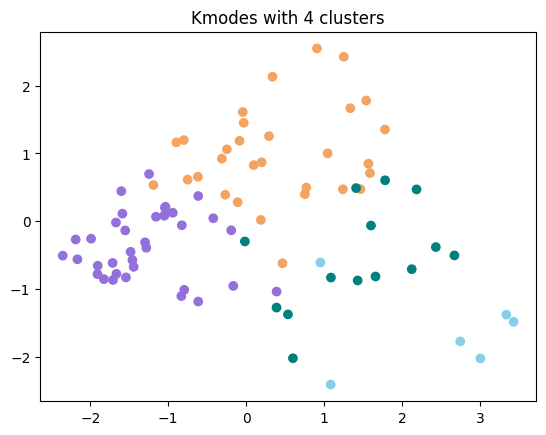

In [4]:
col = np.array(['teal', 'sandybrown', 'mediumpurple', 'skyblue', 'grey','purple', 'yellow', 'black', 'pink', 'brown', 'cyan', 'magenta'])

df_clusters_mode = pd.DataFrame(columns=['Cluster', 'Country'])

for i in [4]: #trange(2, 7, desc='Calculating'):
    fig, ax = plt.subplots(1,1)
    kmodes = KModes(n_clusters=i, init='Huang', n_init=100, random_state=0).fit(vectors)
    labels = kmodes.labels_
    ax.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=col[labels])
    ax.title.set_text('Kmodes with ' + str(i) + ' clusters')
    
    plt.savefig('Figures/kmodes_' + str(i) + '.svg')
    
    for clus in range(i):
        name_cluster = str(i) + ' clusters: ' + col[clus]
        all_countries = countries[labels == clus]
        string = ''
        for country in all_countries:
            string += country + ', '
        string = string[:-2]
        df_clusters_mode = pd.concat([df_clusters_mode, pd.DataFrame({'Cluster': [name_cluster], 'Country': [string]})])

df_clusters_mode.to_excel('datasets/Clusters_mode.xlsx', index=False)

Calculating:   0%|          | 0/5 [00:06<?, ?it/s]


NameError: name 'vectors_2d' is not defined

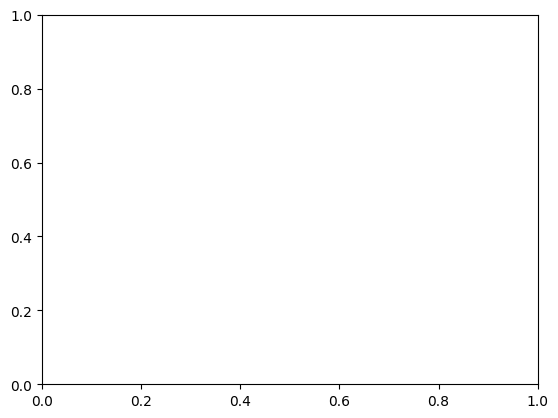

In [5]:
for i in trange(2, 7, desc='Calculating'):
    fig, ax = plt.subplots(1,1)
    kmodes = KModes(n_clusters=i, init='Huang', n_init=100, random_state=0).fit(vectors)
    labels = kmodes.labels_
    ax.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=col[labels])
    ax.title.set_text('Kmodes with ' + str(i) + ' clusters')

In [4]:
from tqdm import trange

def manhattan_distance(v1, v2):
    return np.sum(np.abs(v1 - v2))

def mean_distance(data, cluster):
    return np.sum(manhattan_distances(data[np.newaxis],cluster))/(len(cluster)-1)

WCSS = []
silhouettes_per_k = []
gap_stat = []

clusters_ss = []
outside_ss = []

for i in trange(2, 10, desc='Calculating'):
    kmodes = KModes(n_clusters=i, init='Huang', n_init=100, random_state=0).fit(vectors)
    
    # calculate within cluster sum of squares but with mode instead
    WCSS.append(kmodes.cost_)
    
    # for each cluster take its within cluster sum of squares
    centroids = kmodes.cluster_centroids_
    labels = kmodes.labels_
    wss = []
    bss = []
    for label in np.unique(labels):
        # get cluster and outsiders
        cluster = vectors[labels == label]
        outside_cluster = vectors[labels != label]
        
        # get centroid of cluster
        centroid = centroids[label]
        
        # calculate within cluster sum of squares
        cluster_ss = np.sum(manhattan_distances(centroid[np.newaxis],cluster))
        wss.append(cluster_ss)
        
        # calculate between cluster sum of squares
        between_ss = np.sum(manhattan_distances(centroid[np.newaxis],outside_cluster))
        bss.append(between_ss)
    clusters_ss.append(wss)
    outside_ss.append(bss)
    
    # calculate silhouette
    silhouette = []
    for i_data in range(vectors.shape[0]):
        # get data and label
        data = vectors[i_data]
        label = labels[i_data]
        
        # calculate a(i)
        a = mean_distance(data, vectors[labels == label])
        
        # calculate b(i)
        bs = []
        for i_label in np.unique(labels):
            if i_label != label:
                bs.append(mean_distance(data, vectors[labels == i_label]))
    
        b = np.min(np.array(bs))
        
        # calculate s(i)
        s = (b - a) / max(a, b)
        silhouette.append(s)
    silhouettes_per_k.append(silhouette)

Calculating: 100%|██████████| 8/8 [01:21<00:00, 10.24s/it]


In [5]:
mean_inside_ss = []
variance_inside_ss = []

mean_outside_ss = []
variance_outside_ss = []

Total_SS = []
Outside_total_SS = []

for i in range(len(clusters_ss)):
    mean_inside_ss.append(np.mean(clusters_ss[i]))
    variance_inside_ss.append(np.sqrt(np.var(clusters_ss[i])))
    Total_SS.append(np.sum(clusters_ss[i]))
    
    mean_outside_ss.append(np.mean(outside_ss[i]))
    variance_outside_ss.append(np.sqrt(np.var(outside_ss[i])))
    Outside_total_SS.append(np.sum(outside_ss[i]))

<BarContainer object of 8 artists>

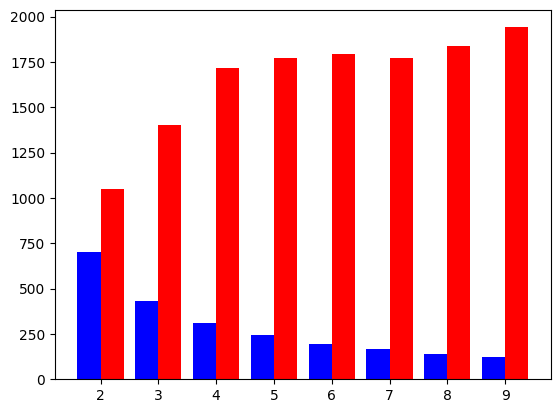

In [7]:
# bar plot of mean outside and inside sum of squares, bars next to each other, outside is red and inside is blue
fig, ax = plt.subplots(1,1)
ax.bar(np.arange(2,10)-0.2, mean_inside_ss, width=0.4, color='b', align='center')
ax.bar(np.arange(2,10)+0.2, mean_outside_ss, width=0.4, color='r', align='center')




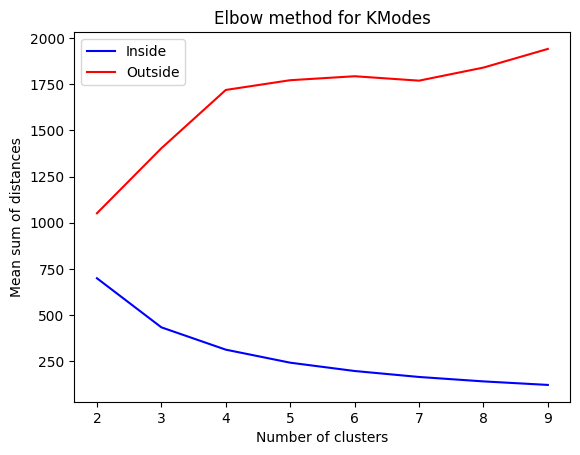

In [7]:
# use elbow
plt.plot(range(2, 10), mean_inside_ss, label='Inside', color='b')
plt.plot(range(2, 10), mean_outside_ss, label='Outside', color='r')

plt.title('Elbow method for KModes')
plt.xlabel('Number of clusters')
plt.ylabel('Mean sum of distances')

plt.legend()
plt.savefig('Figures/elbow_kmodes.svg')

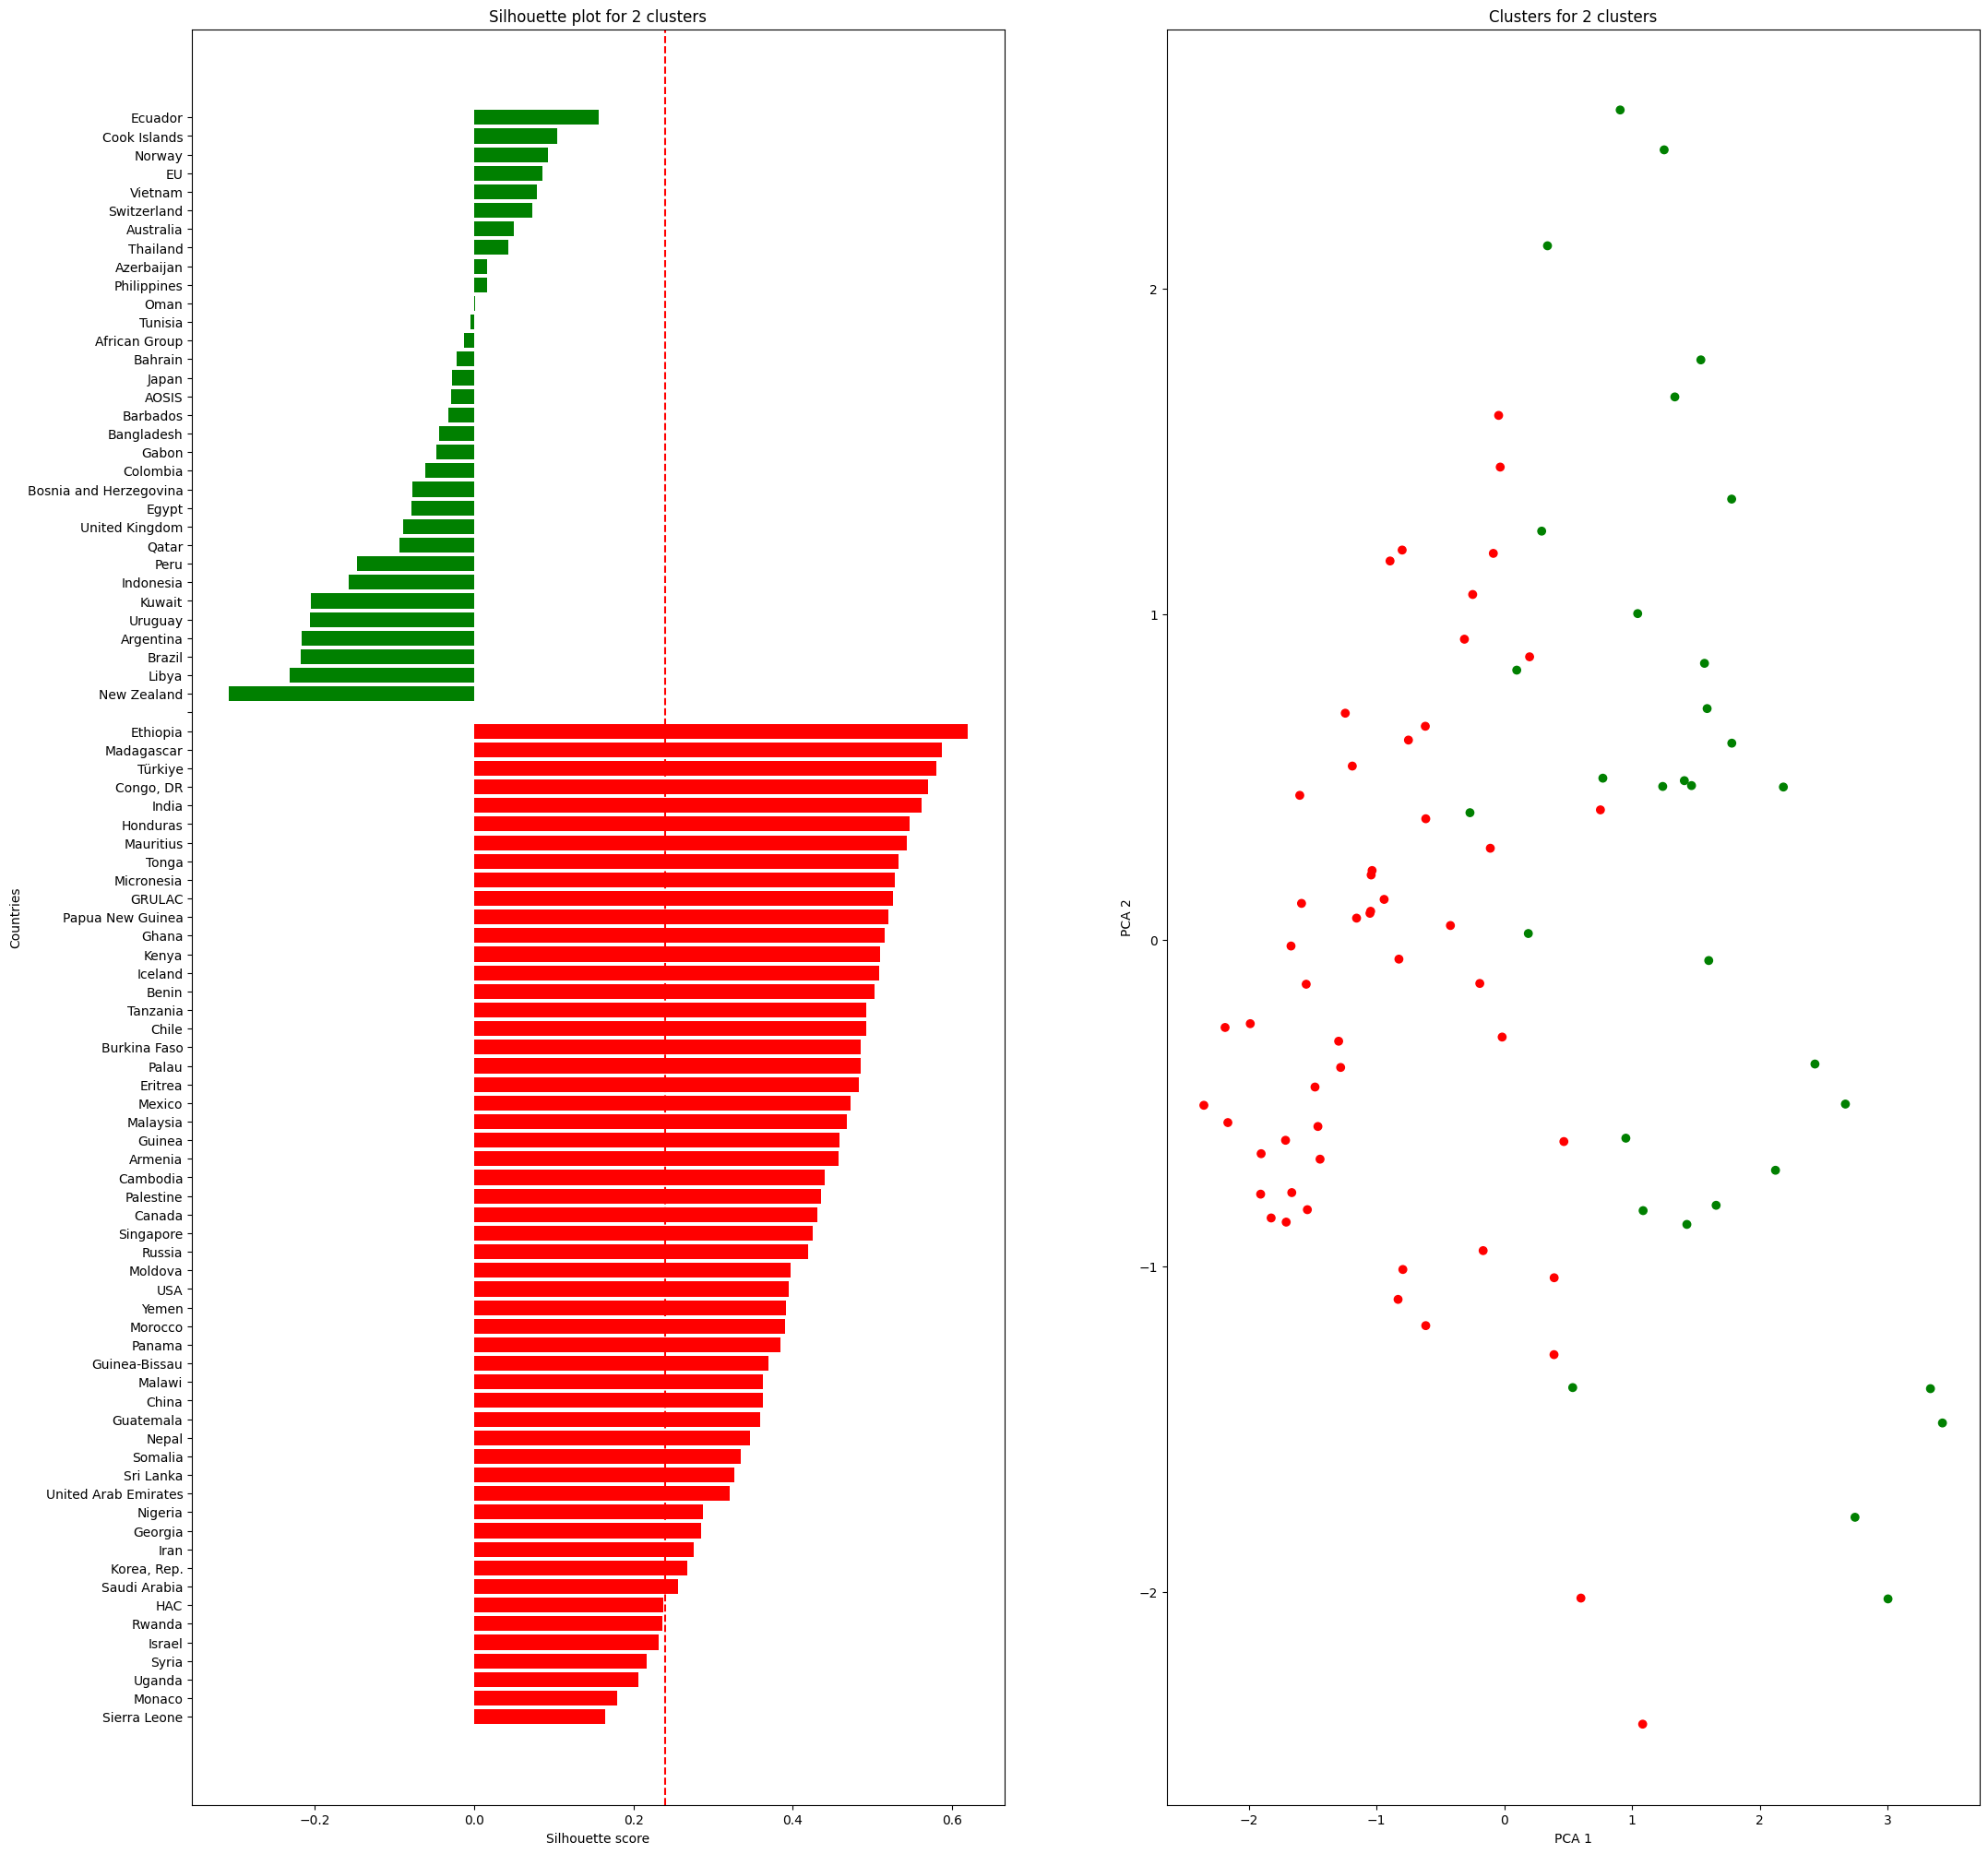

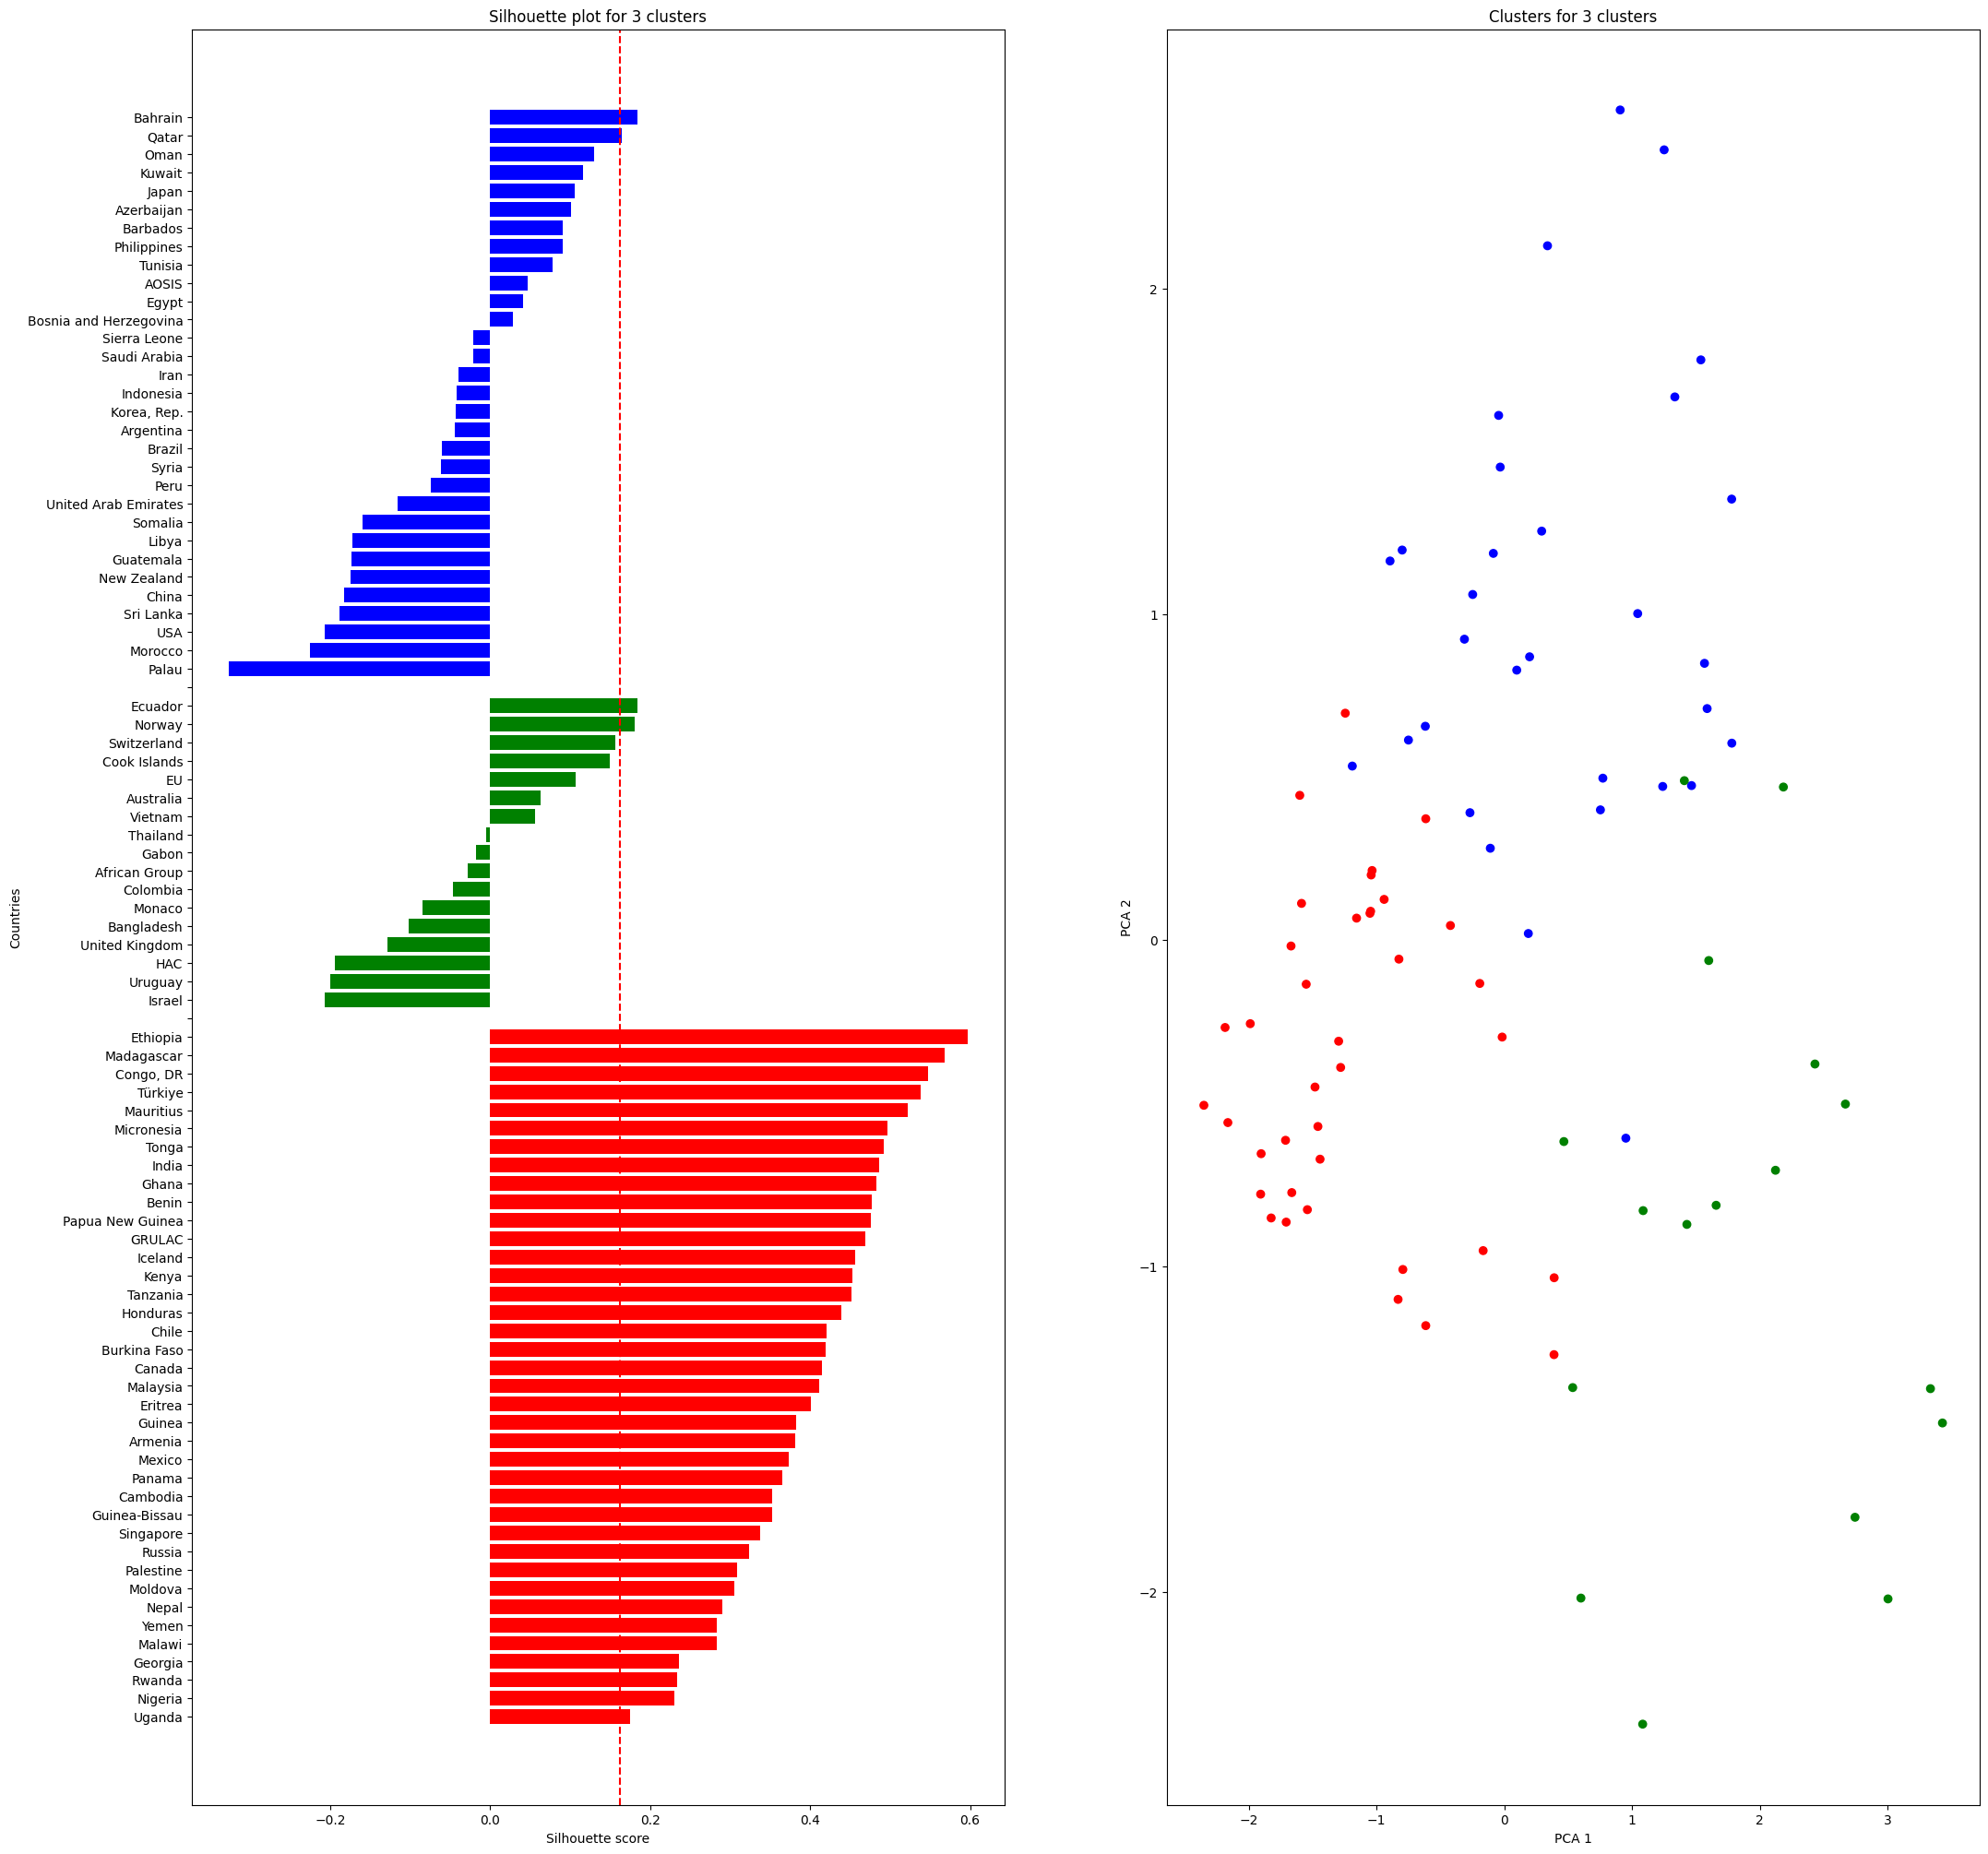

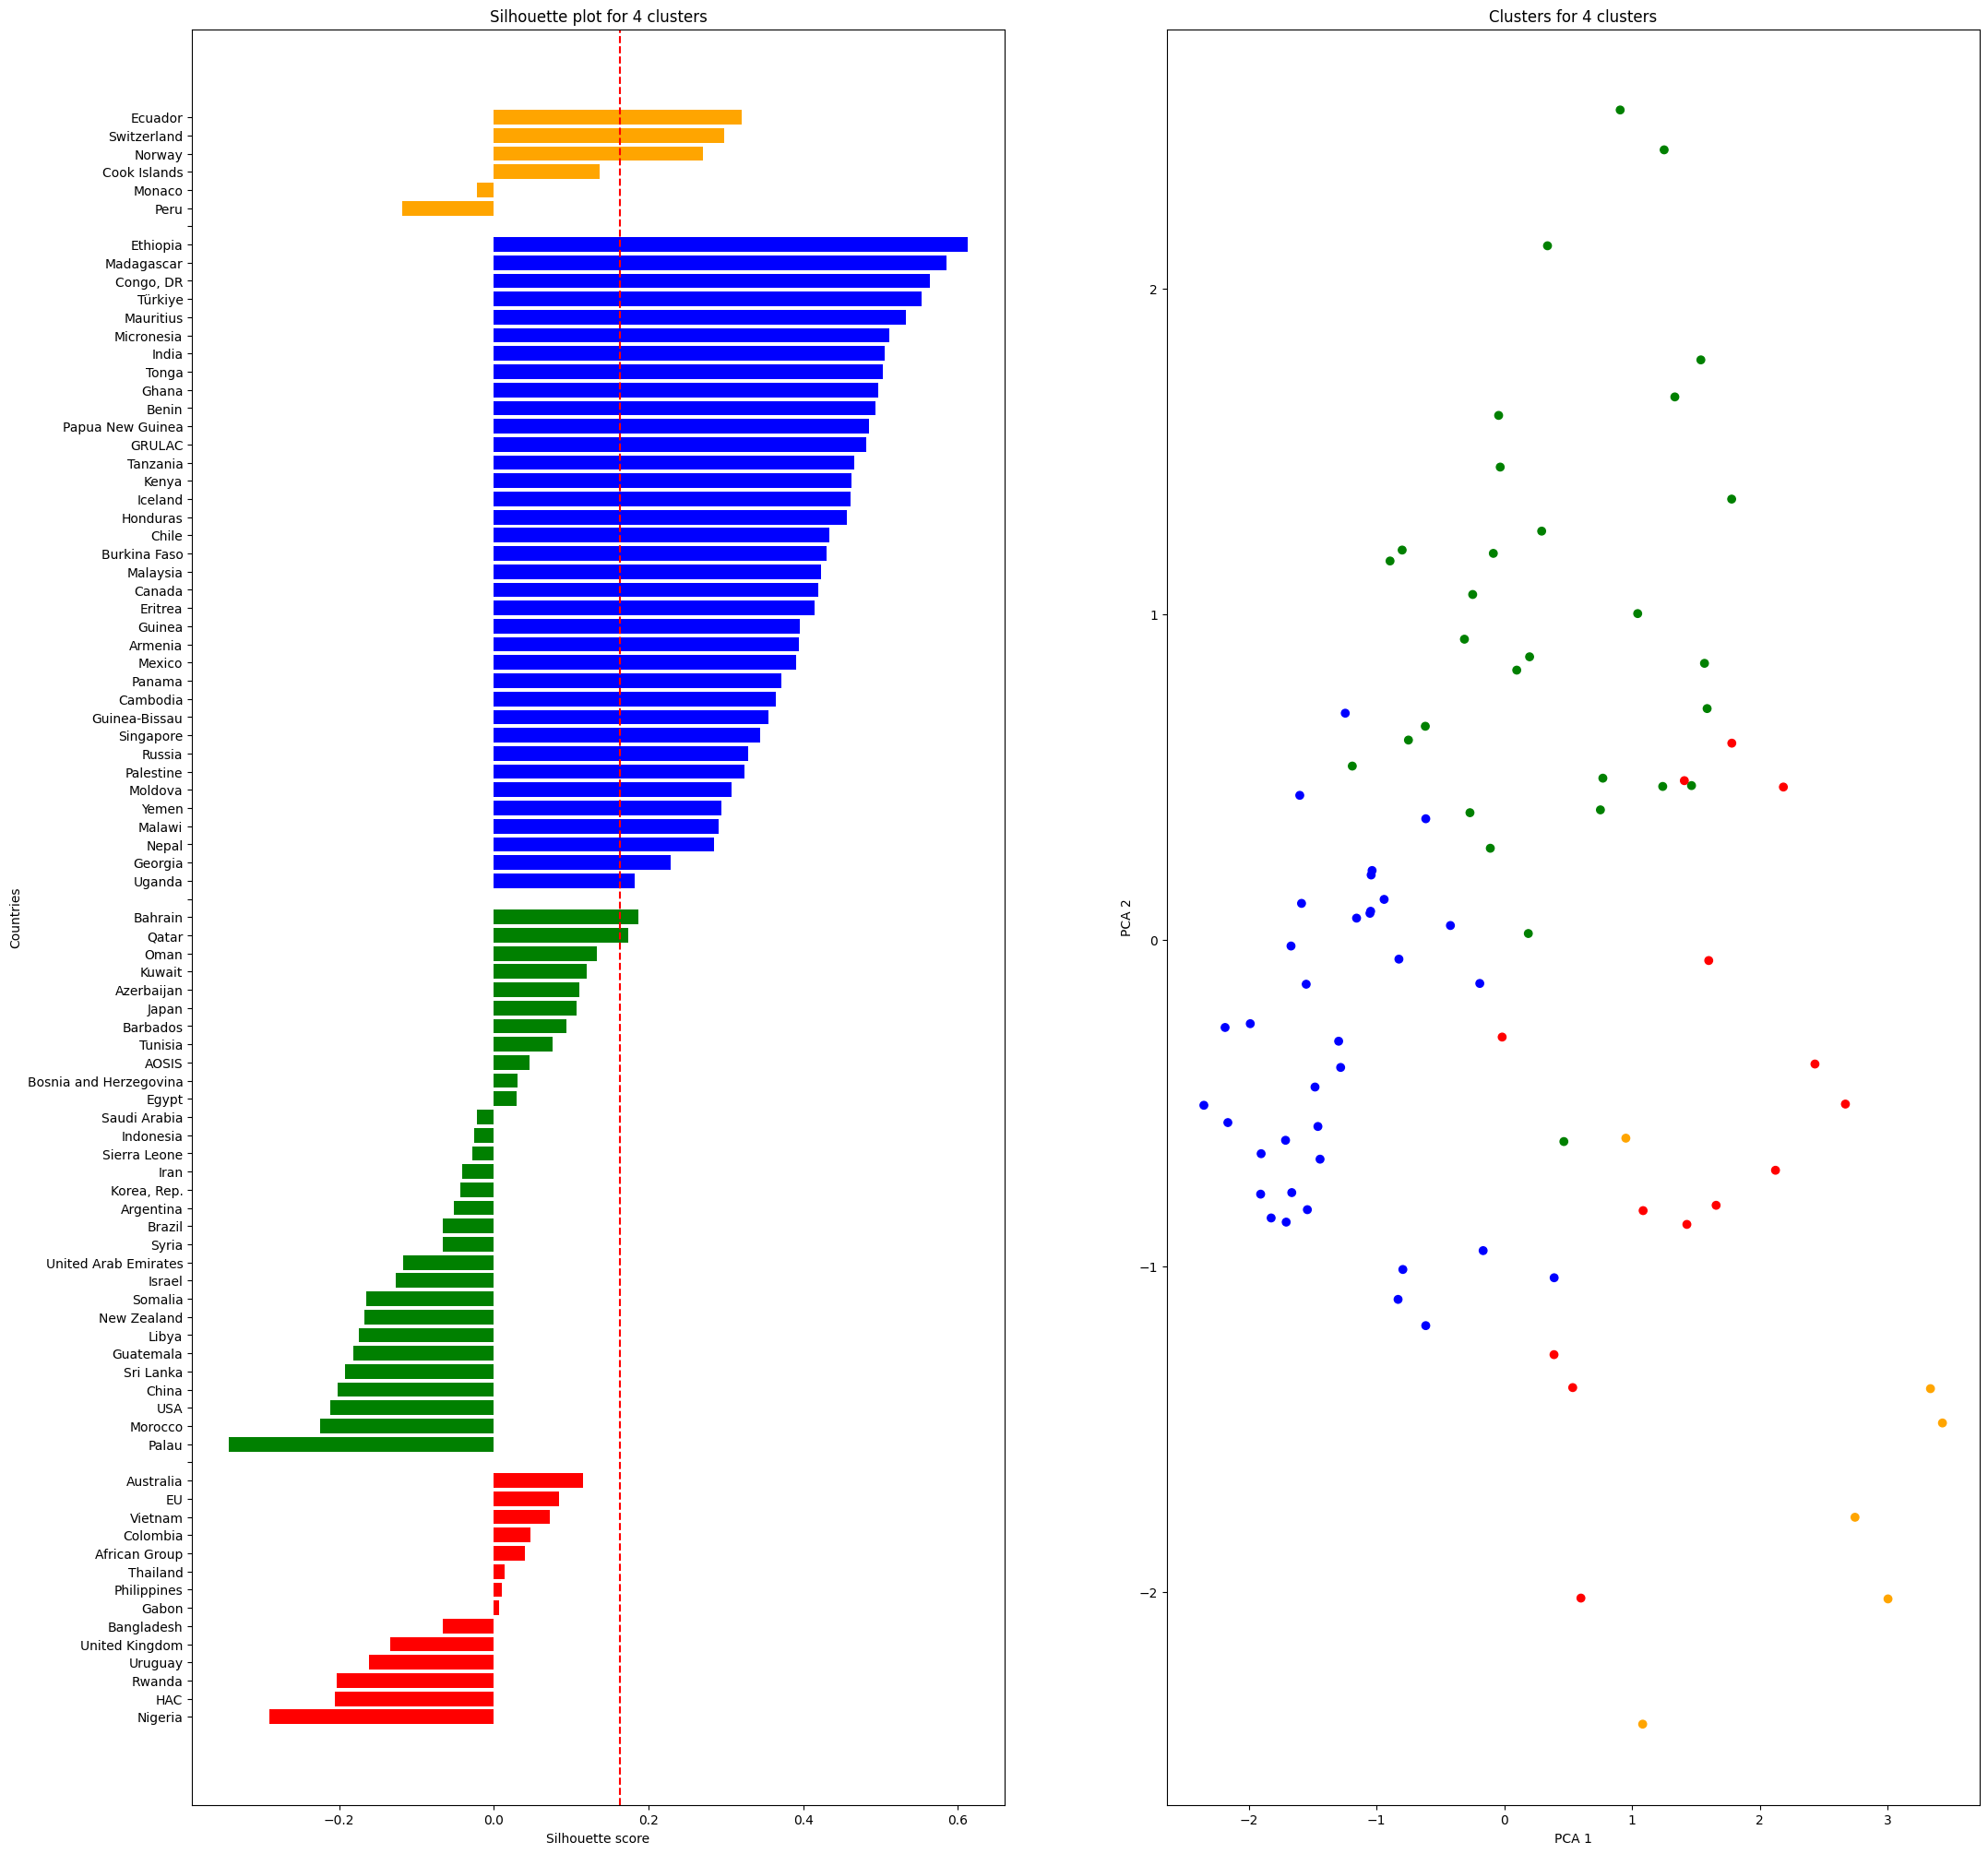

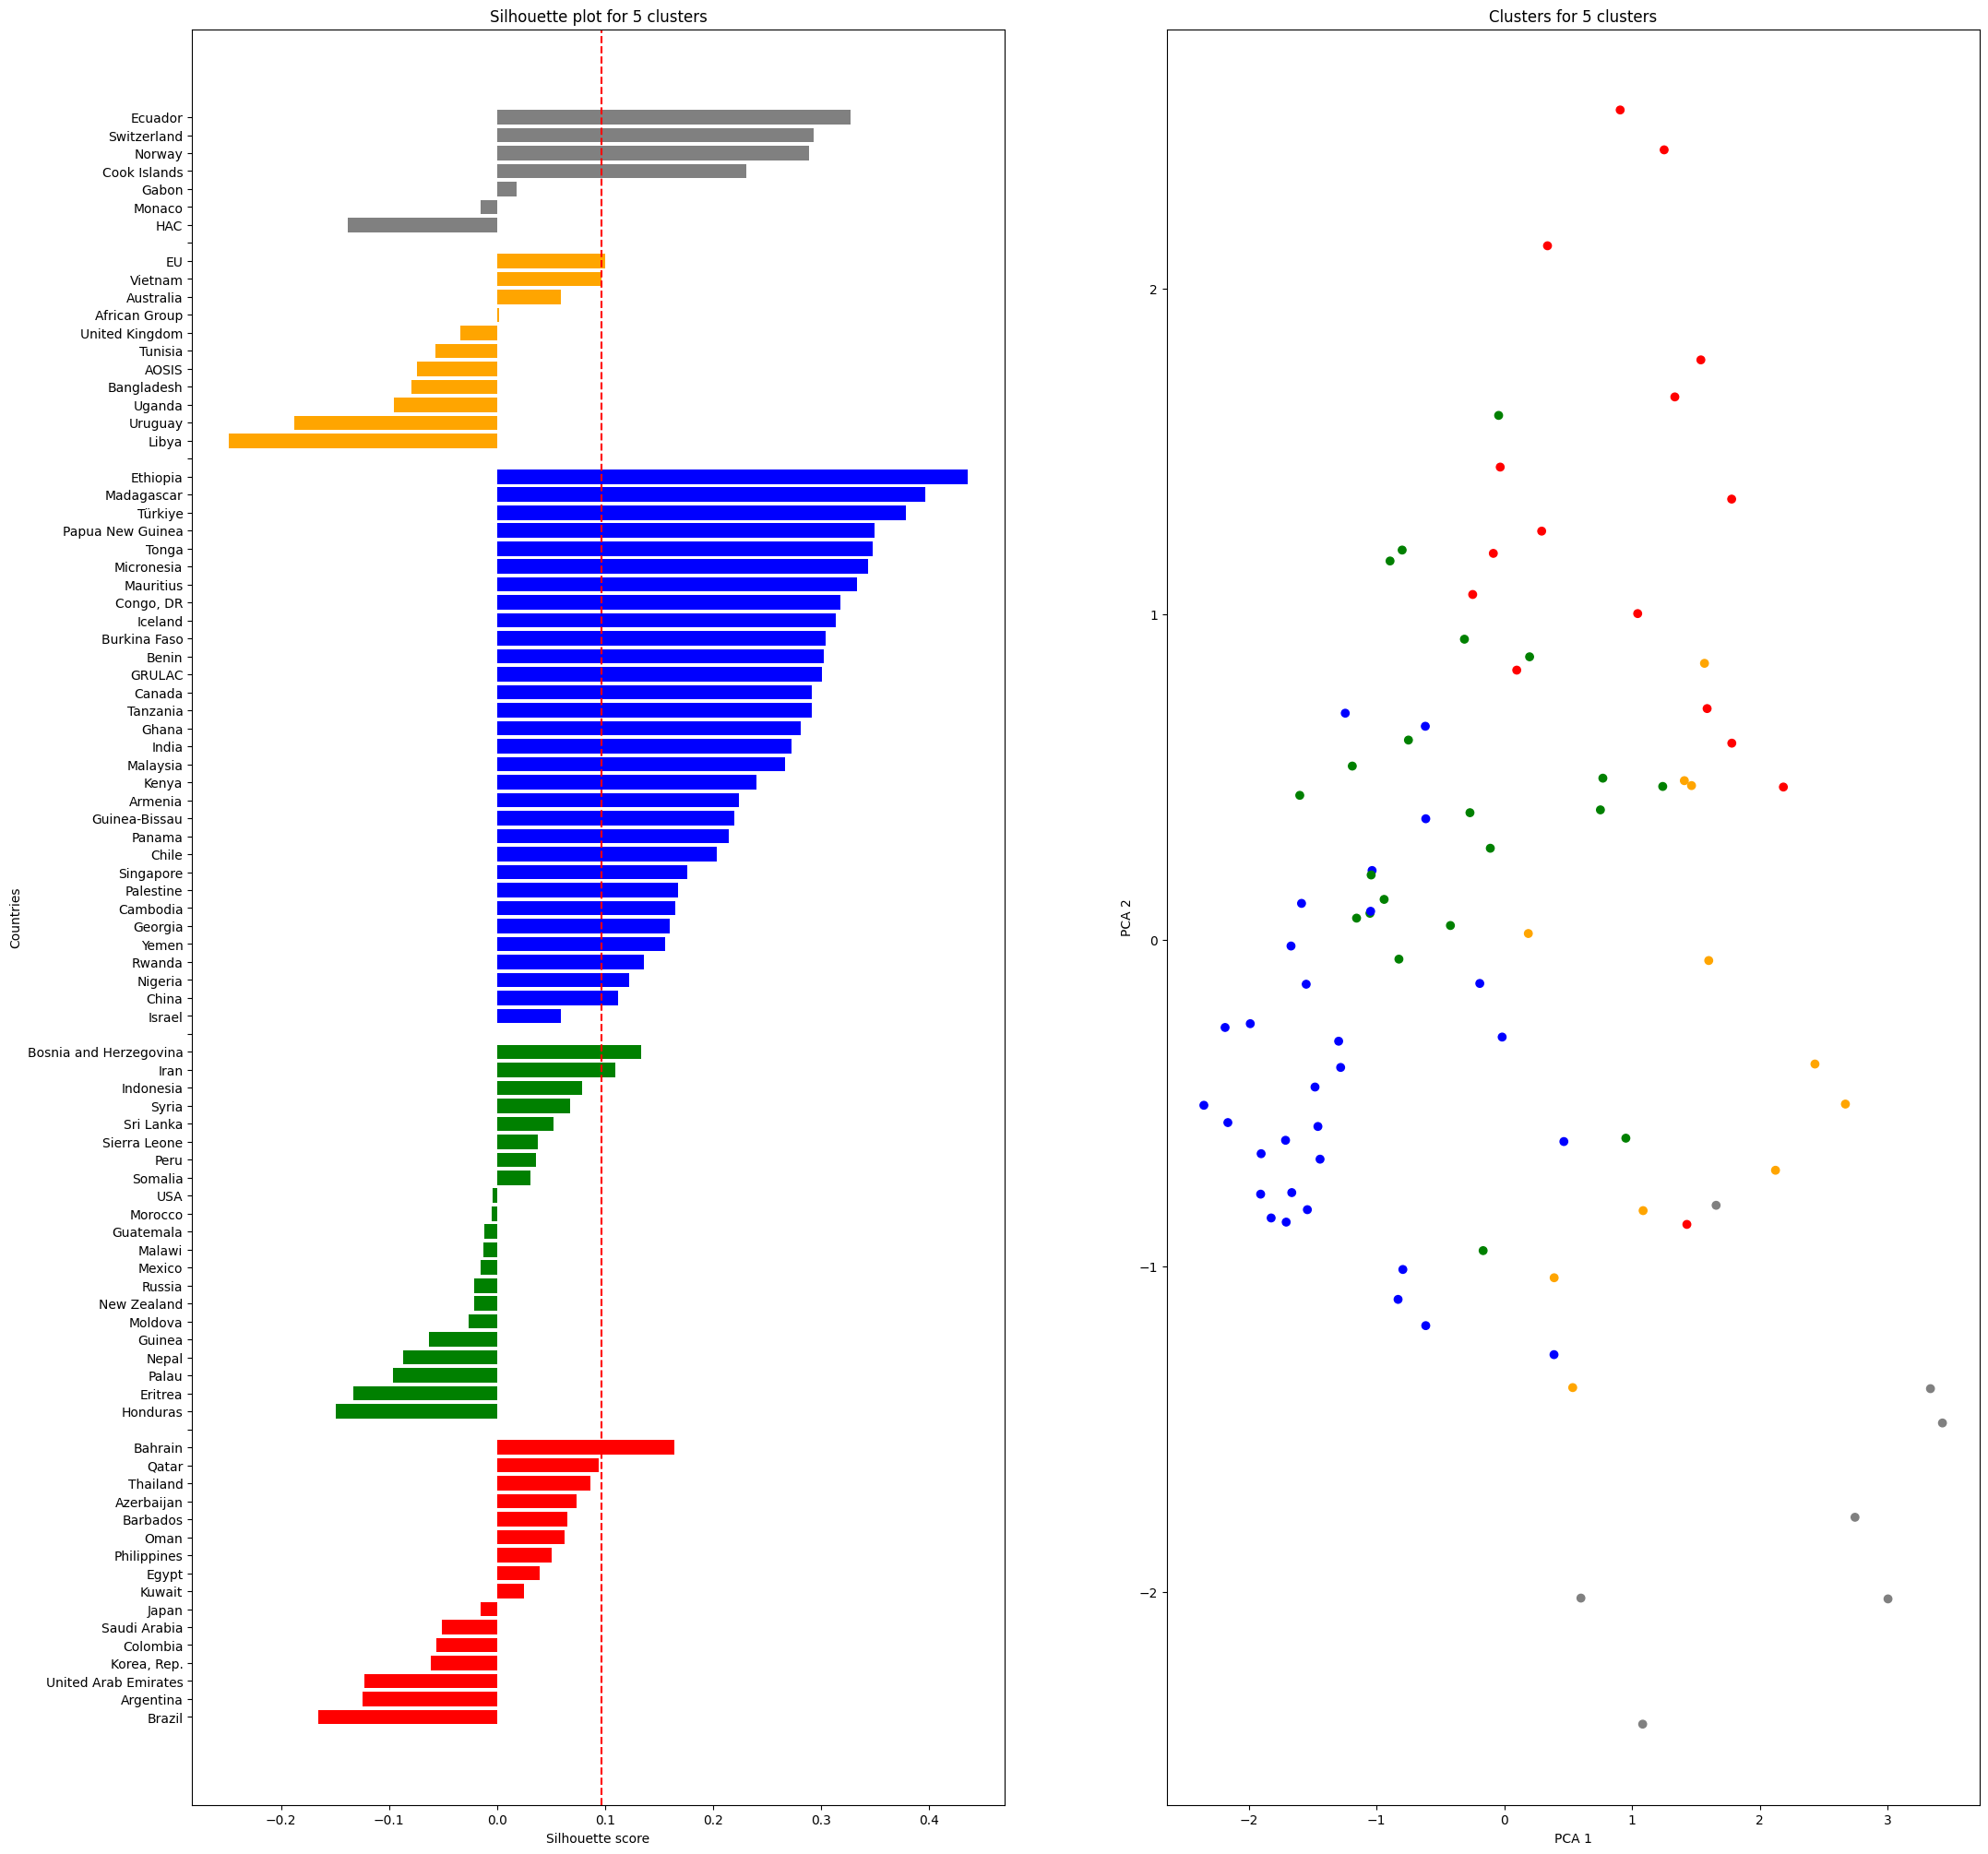

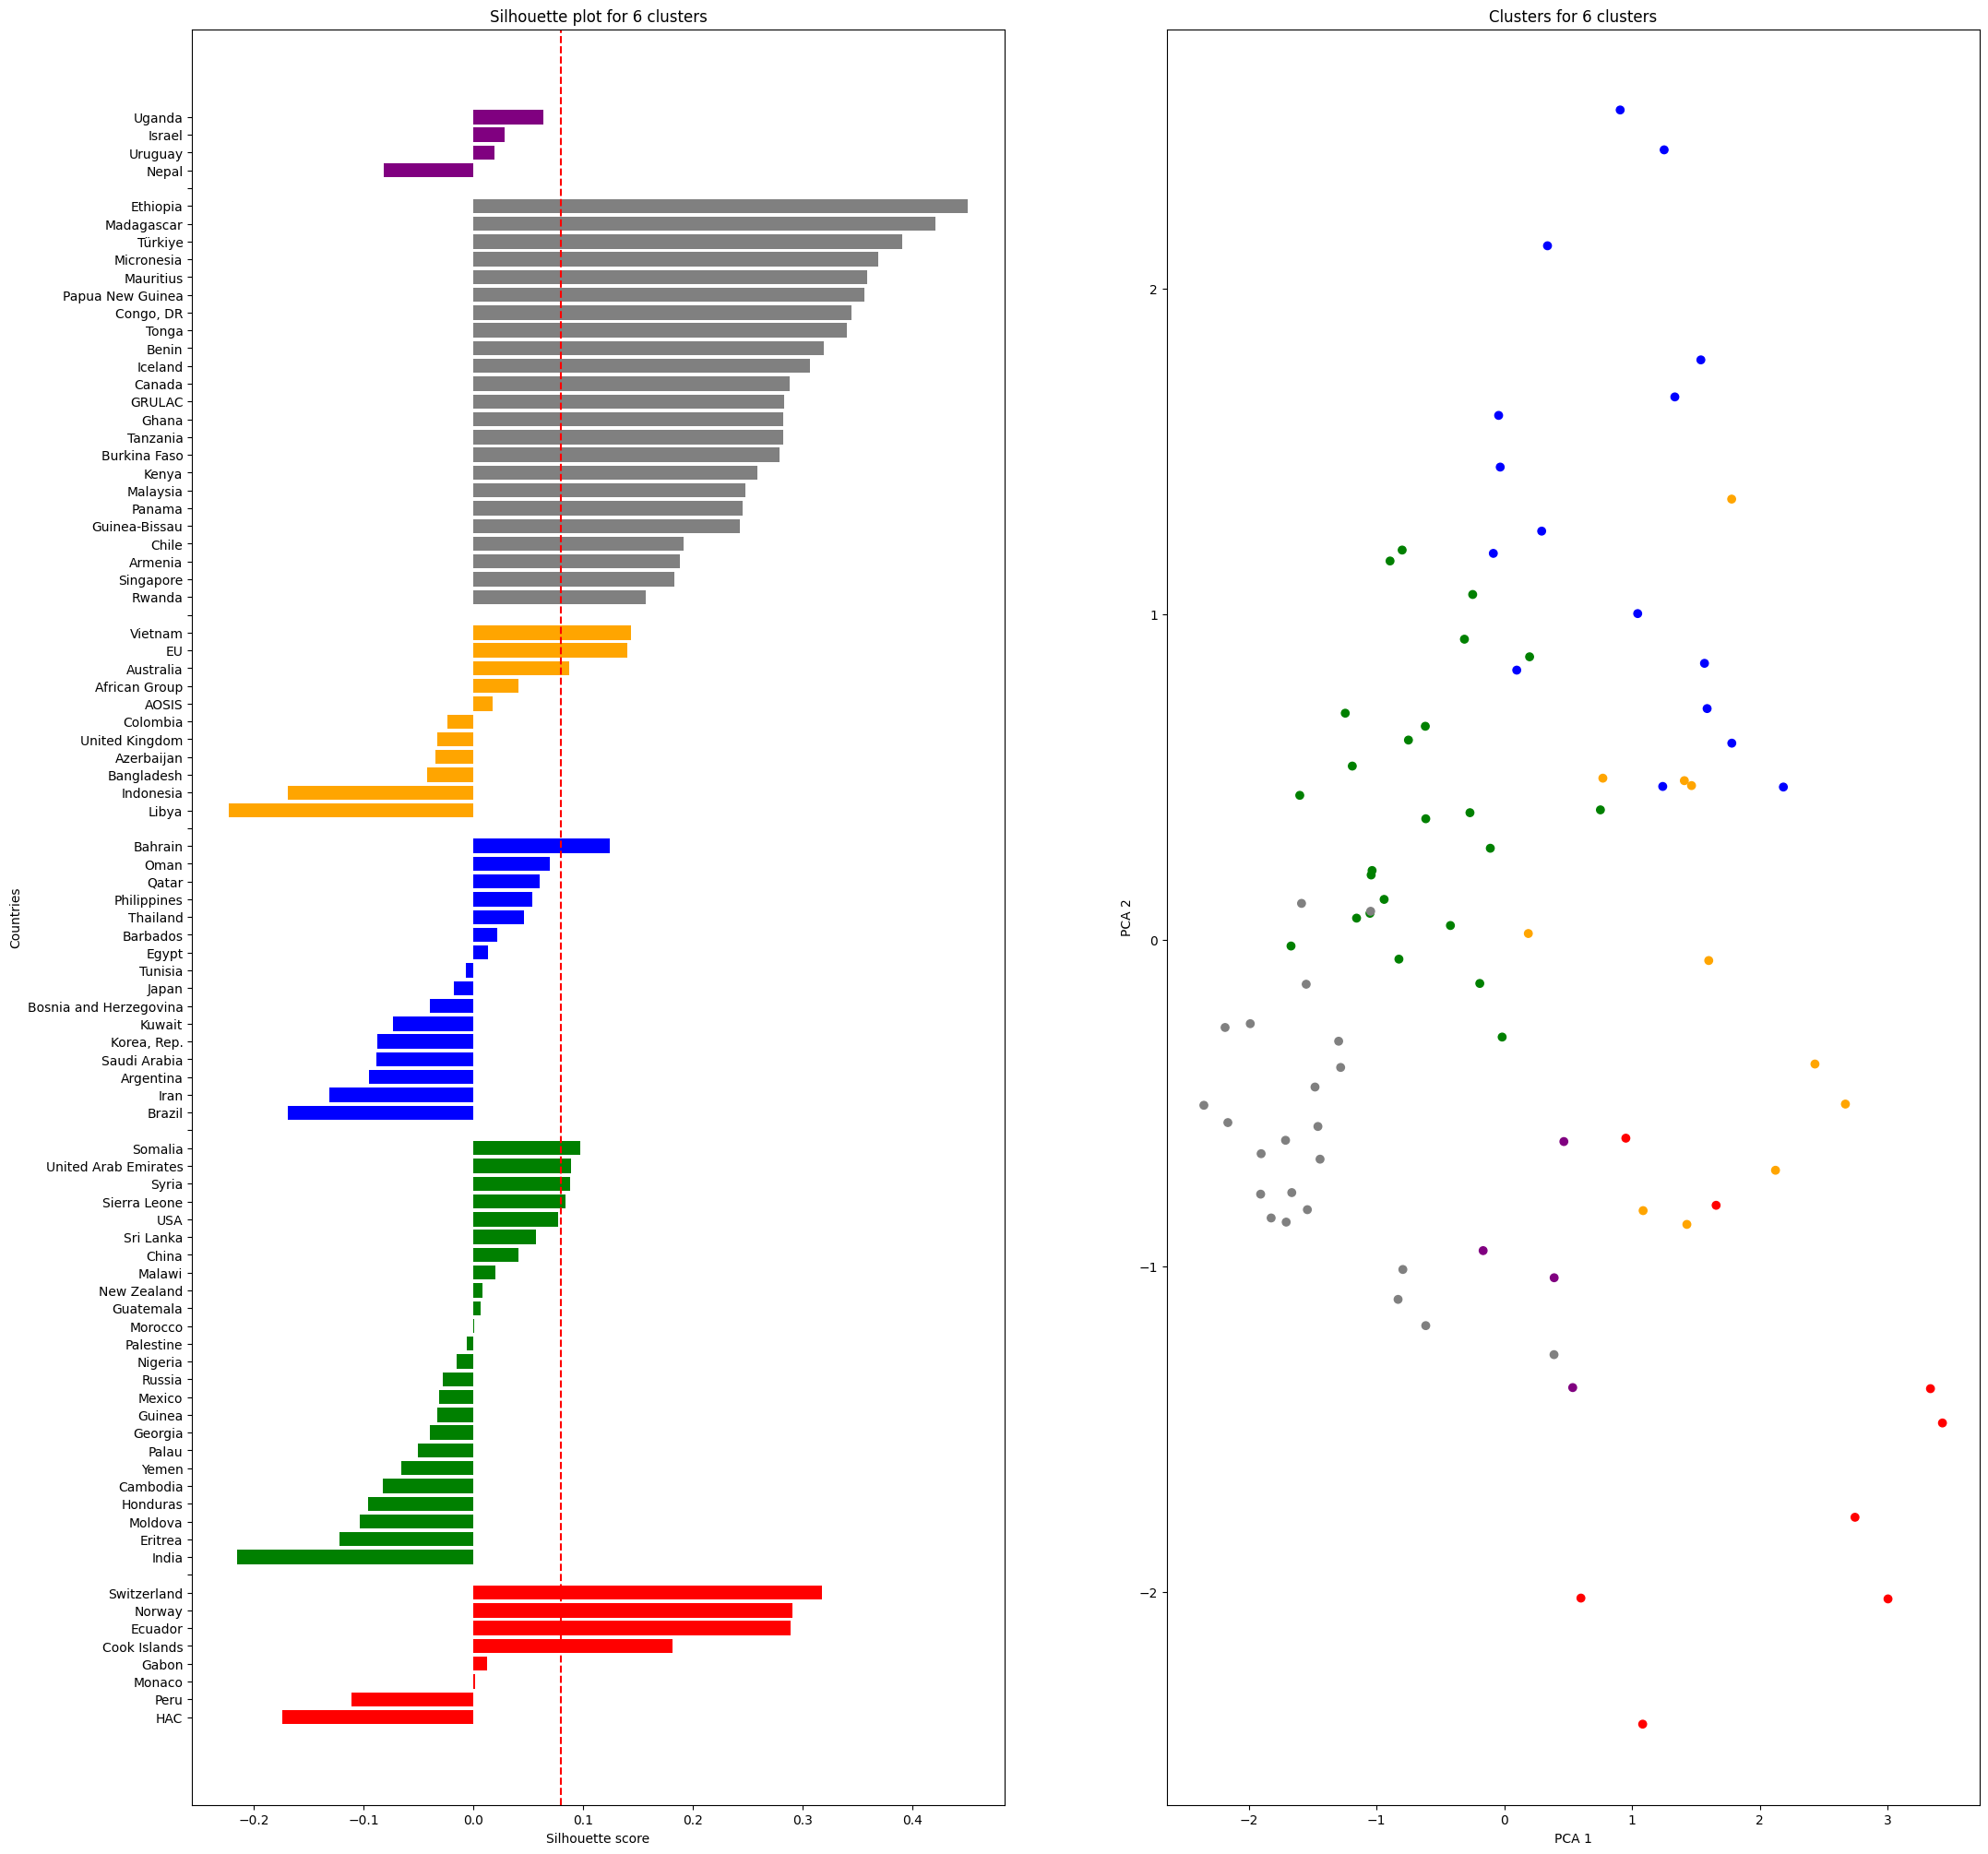

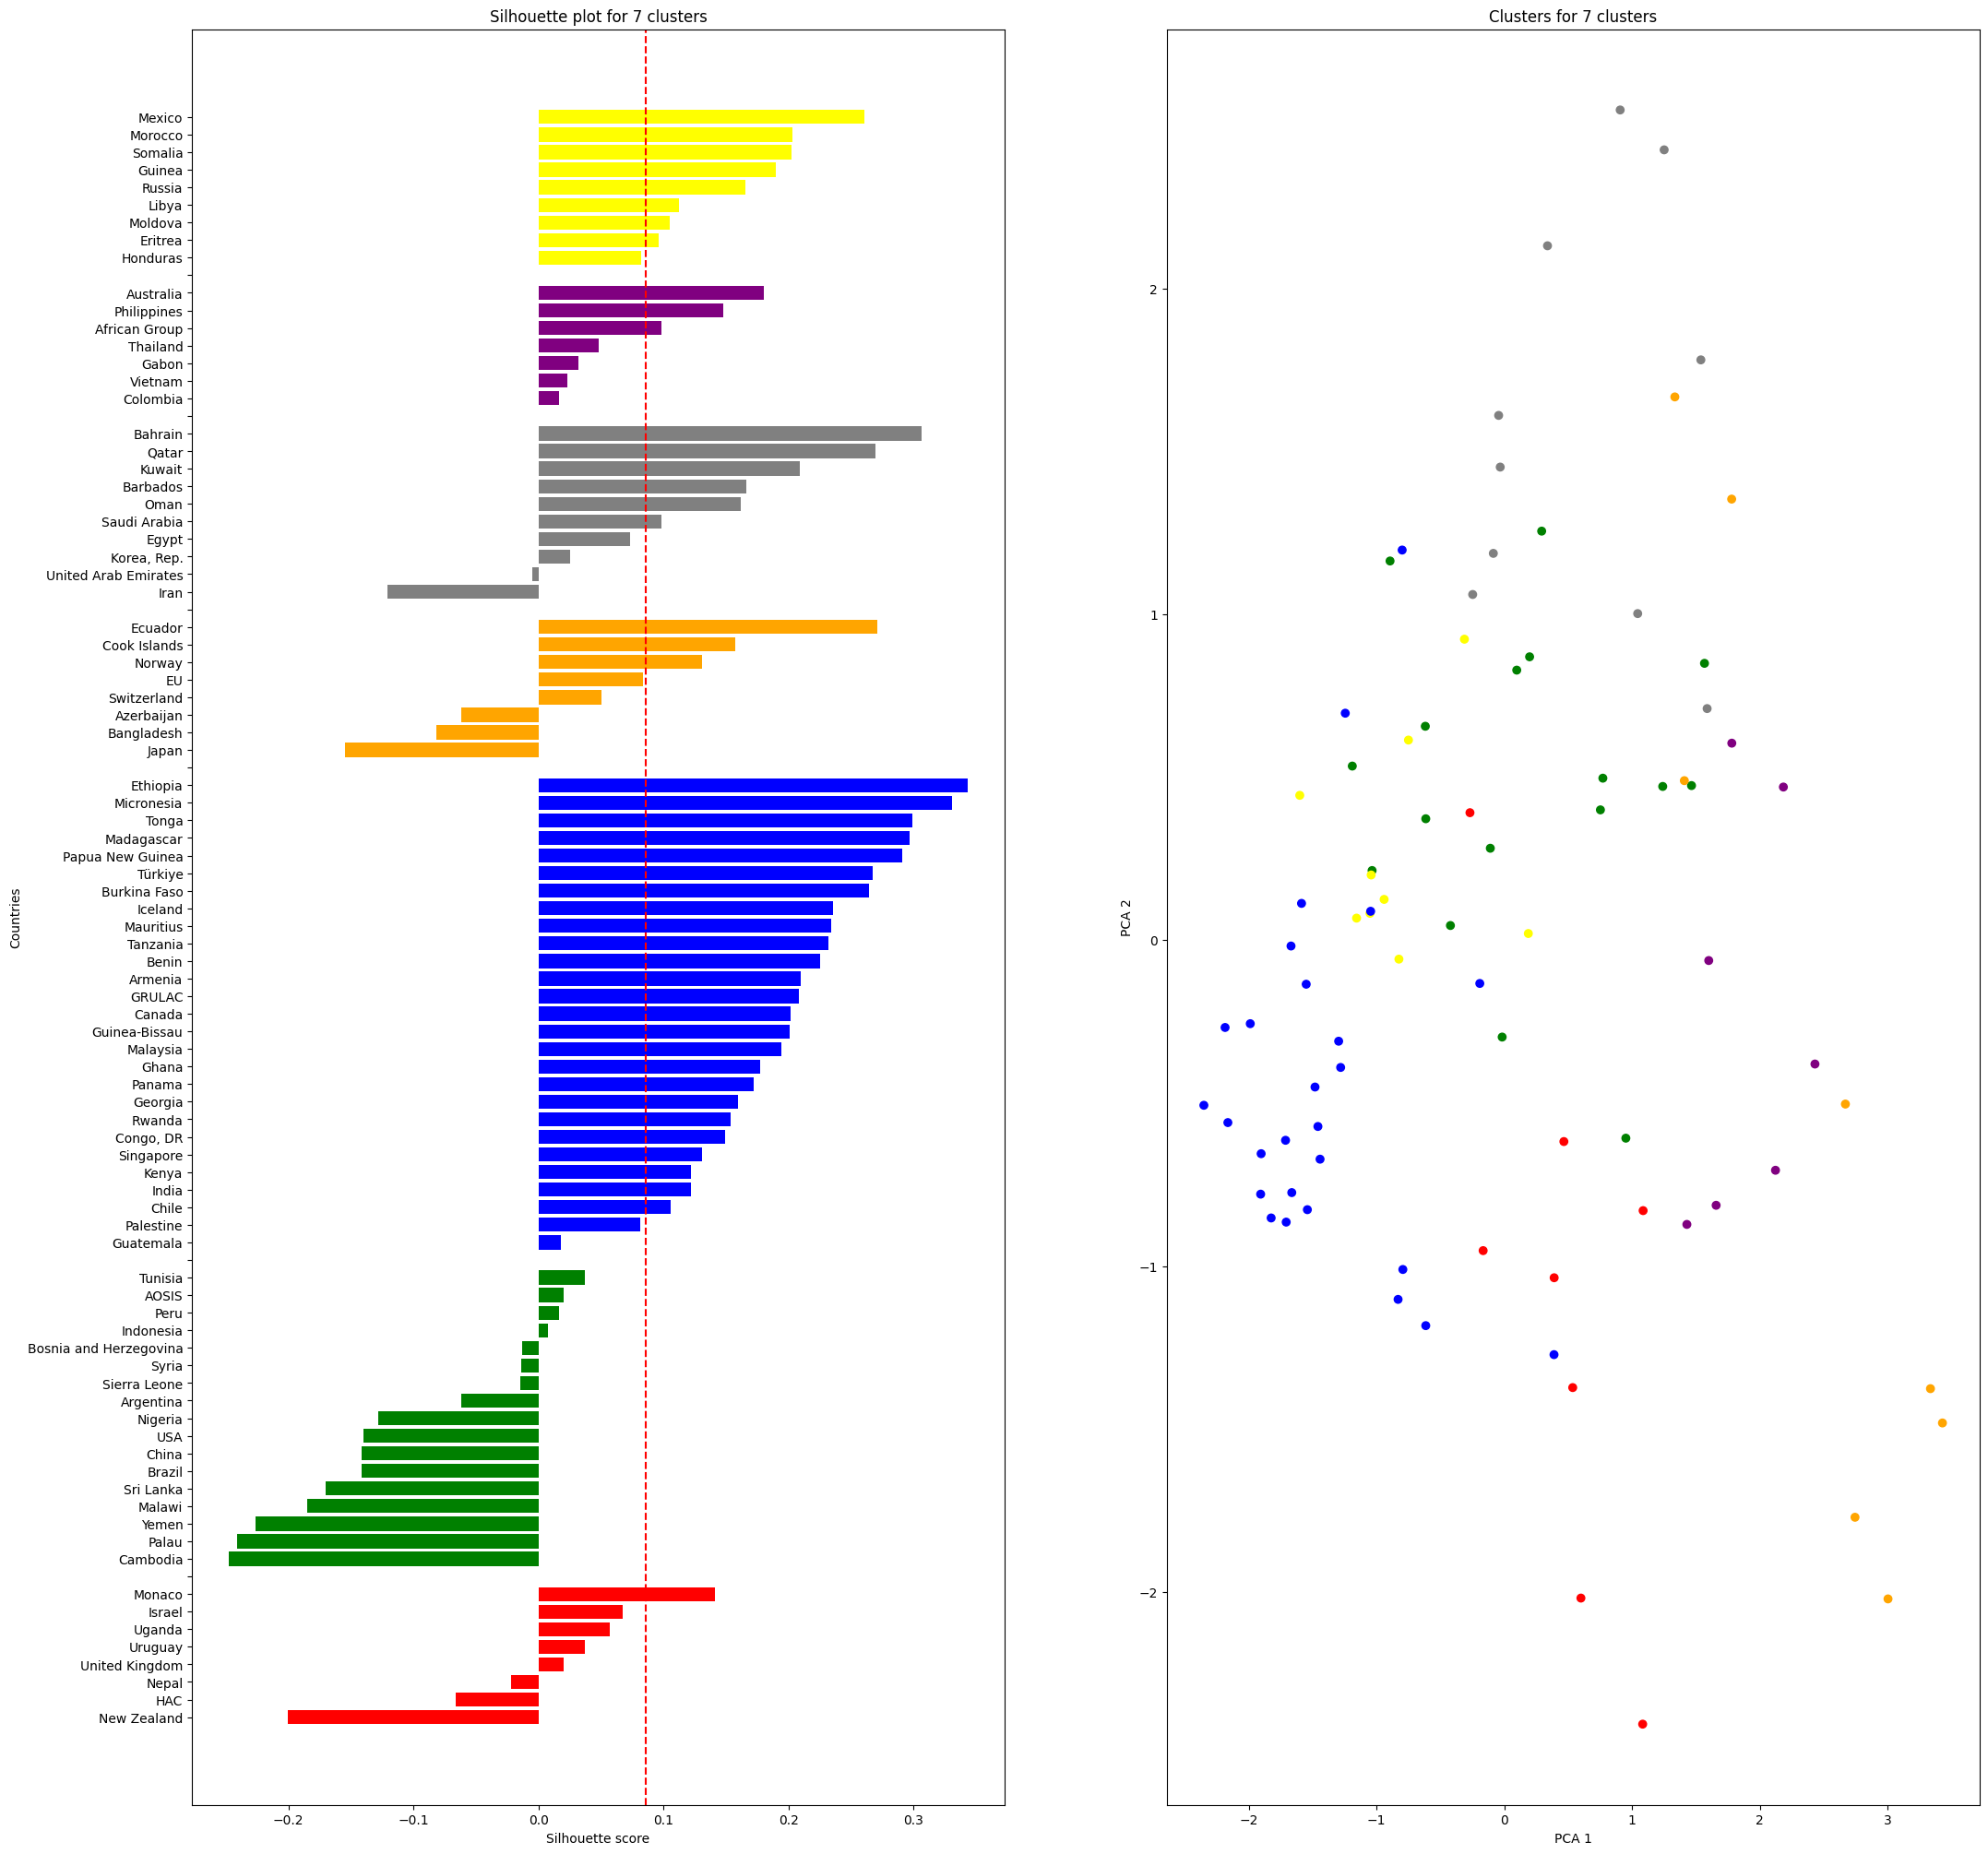

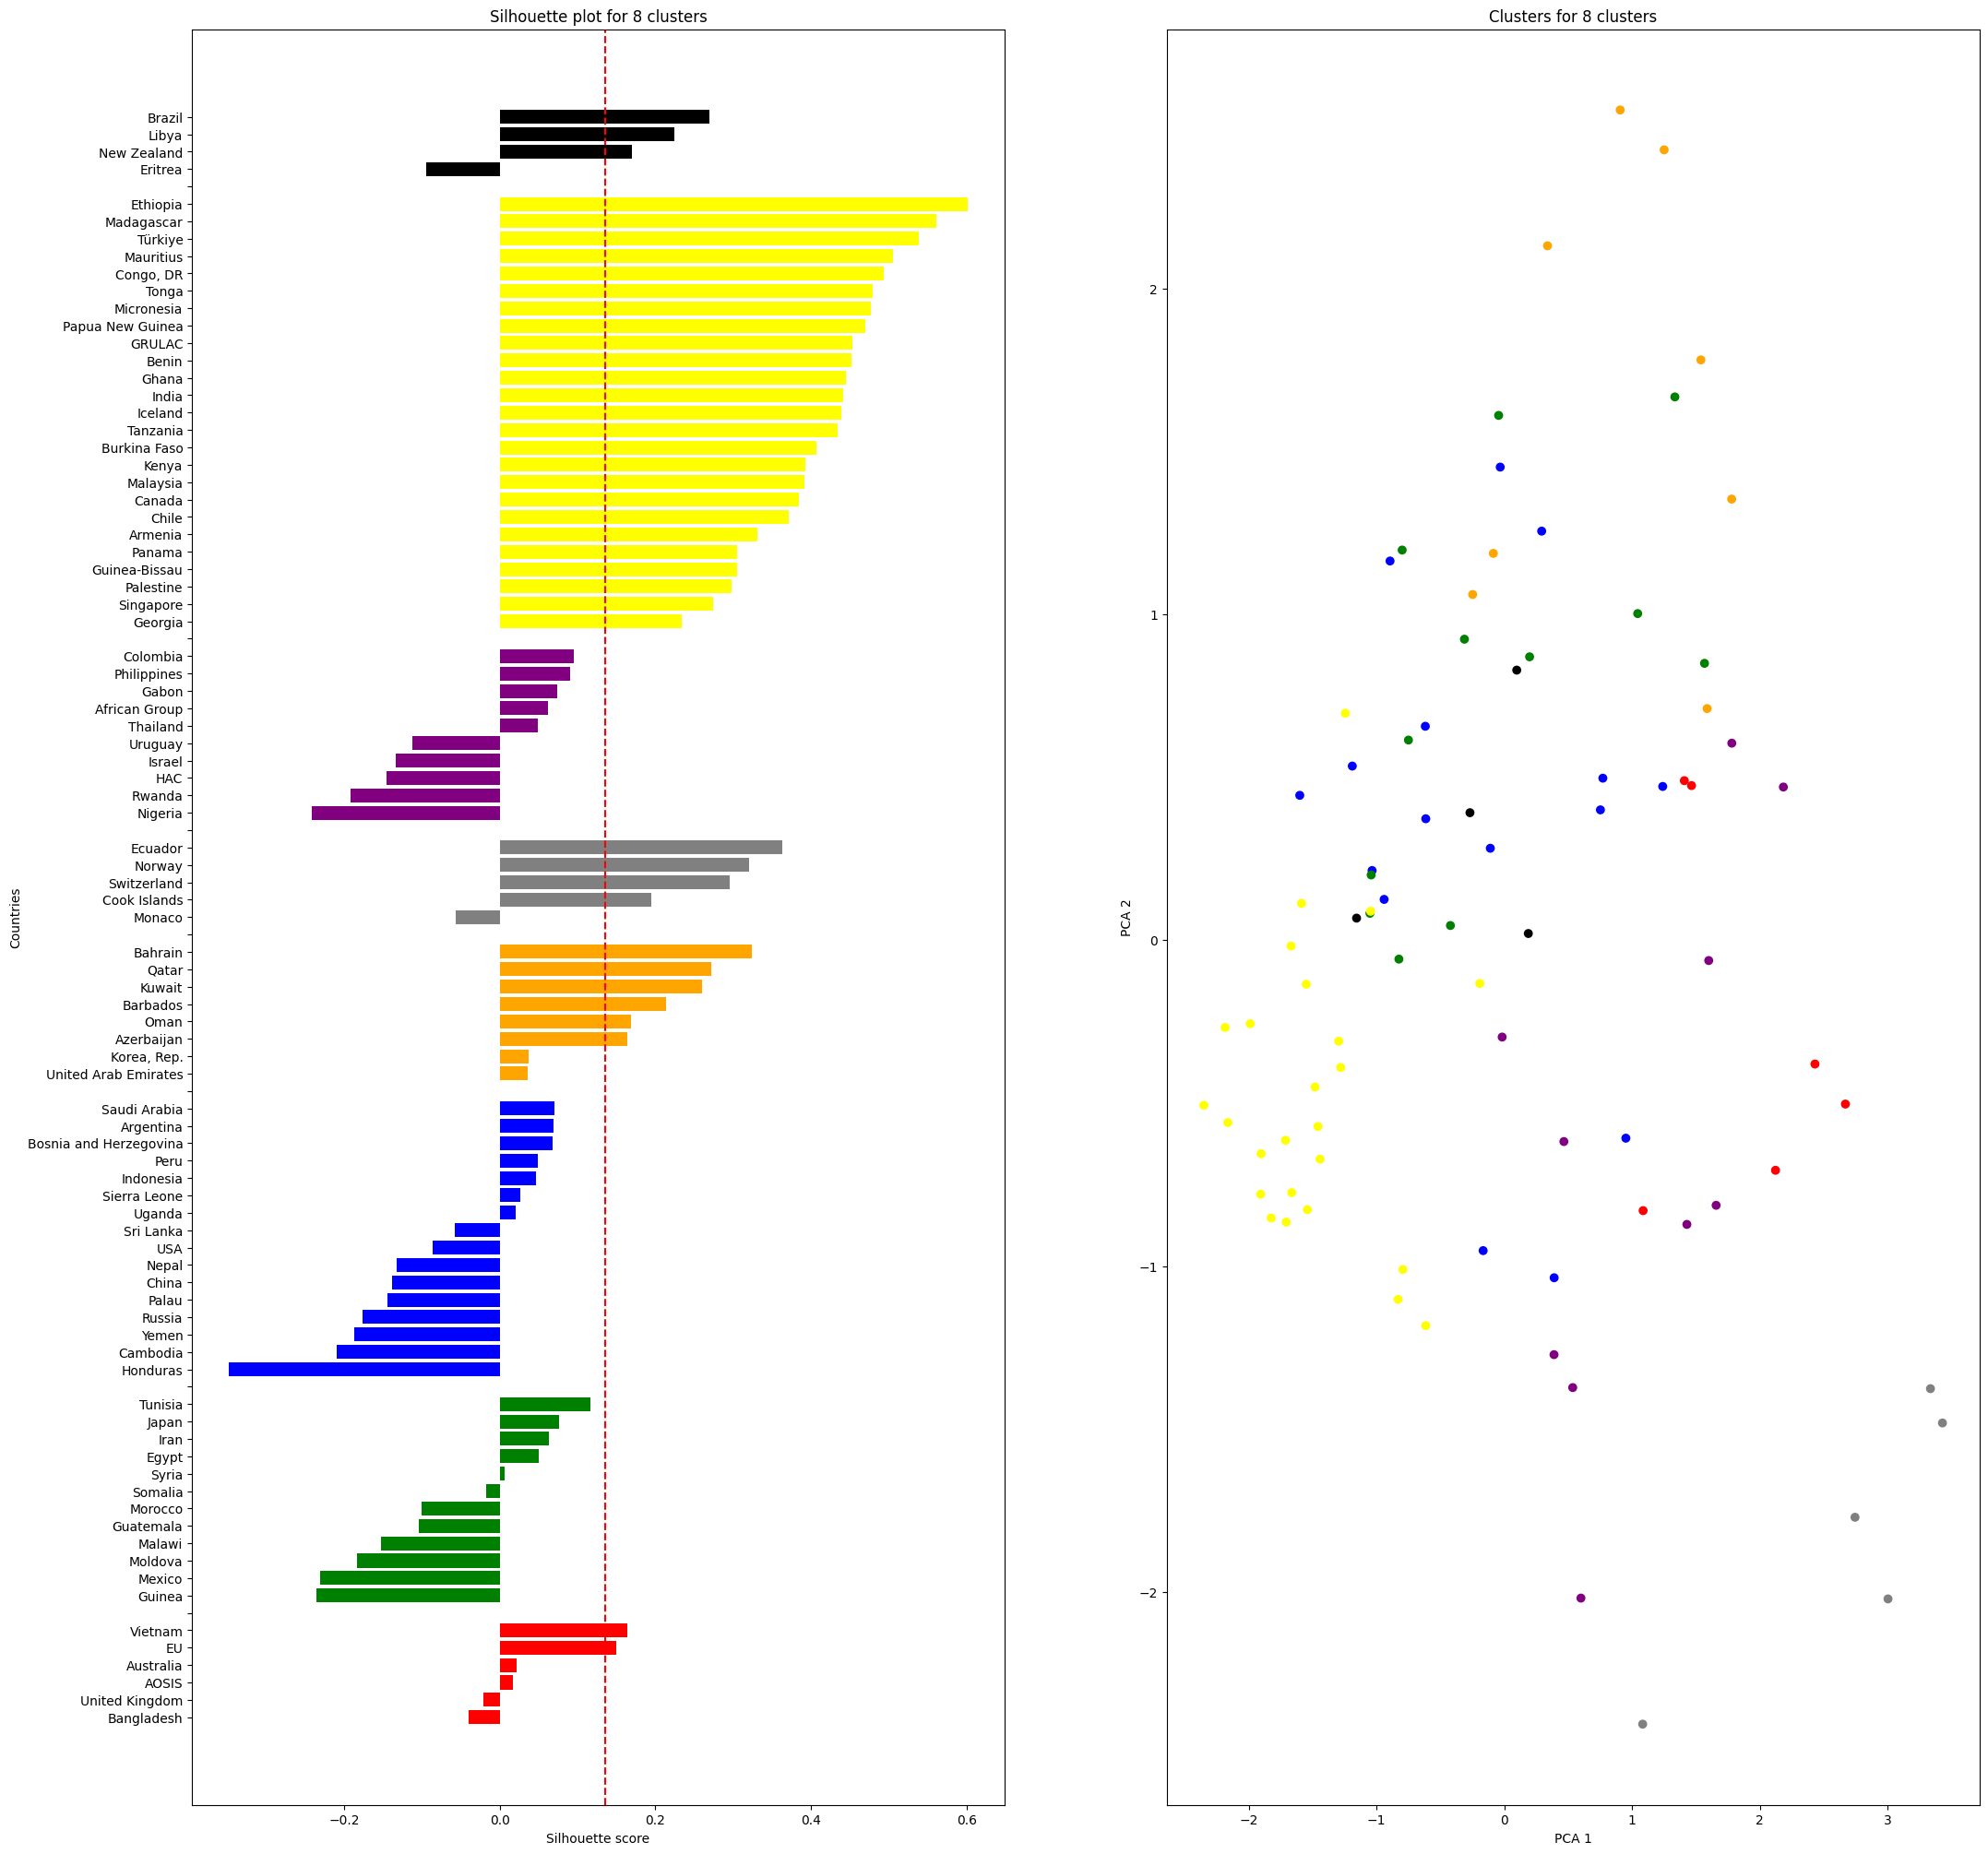

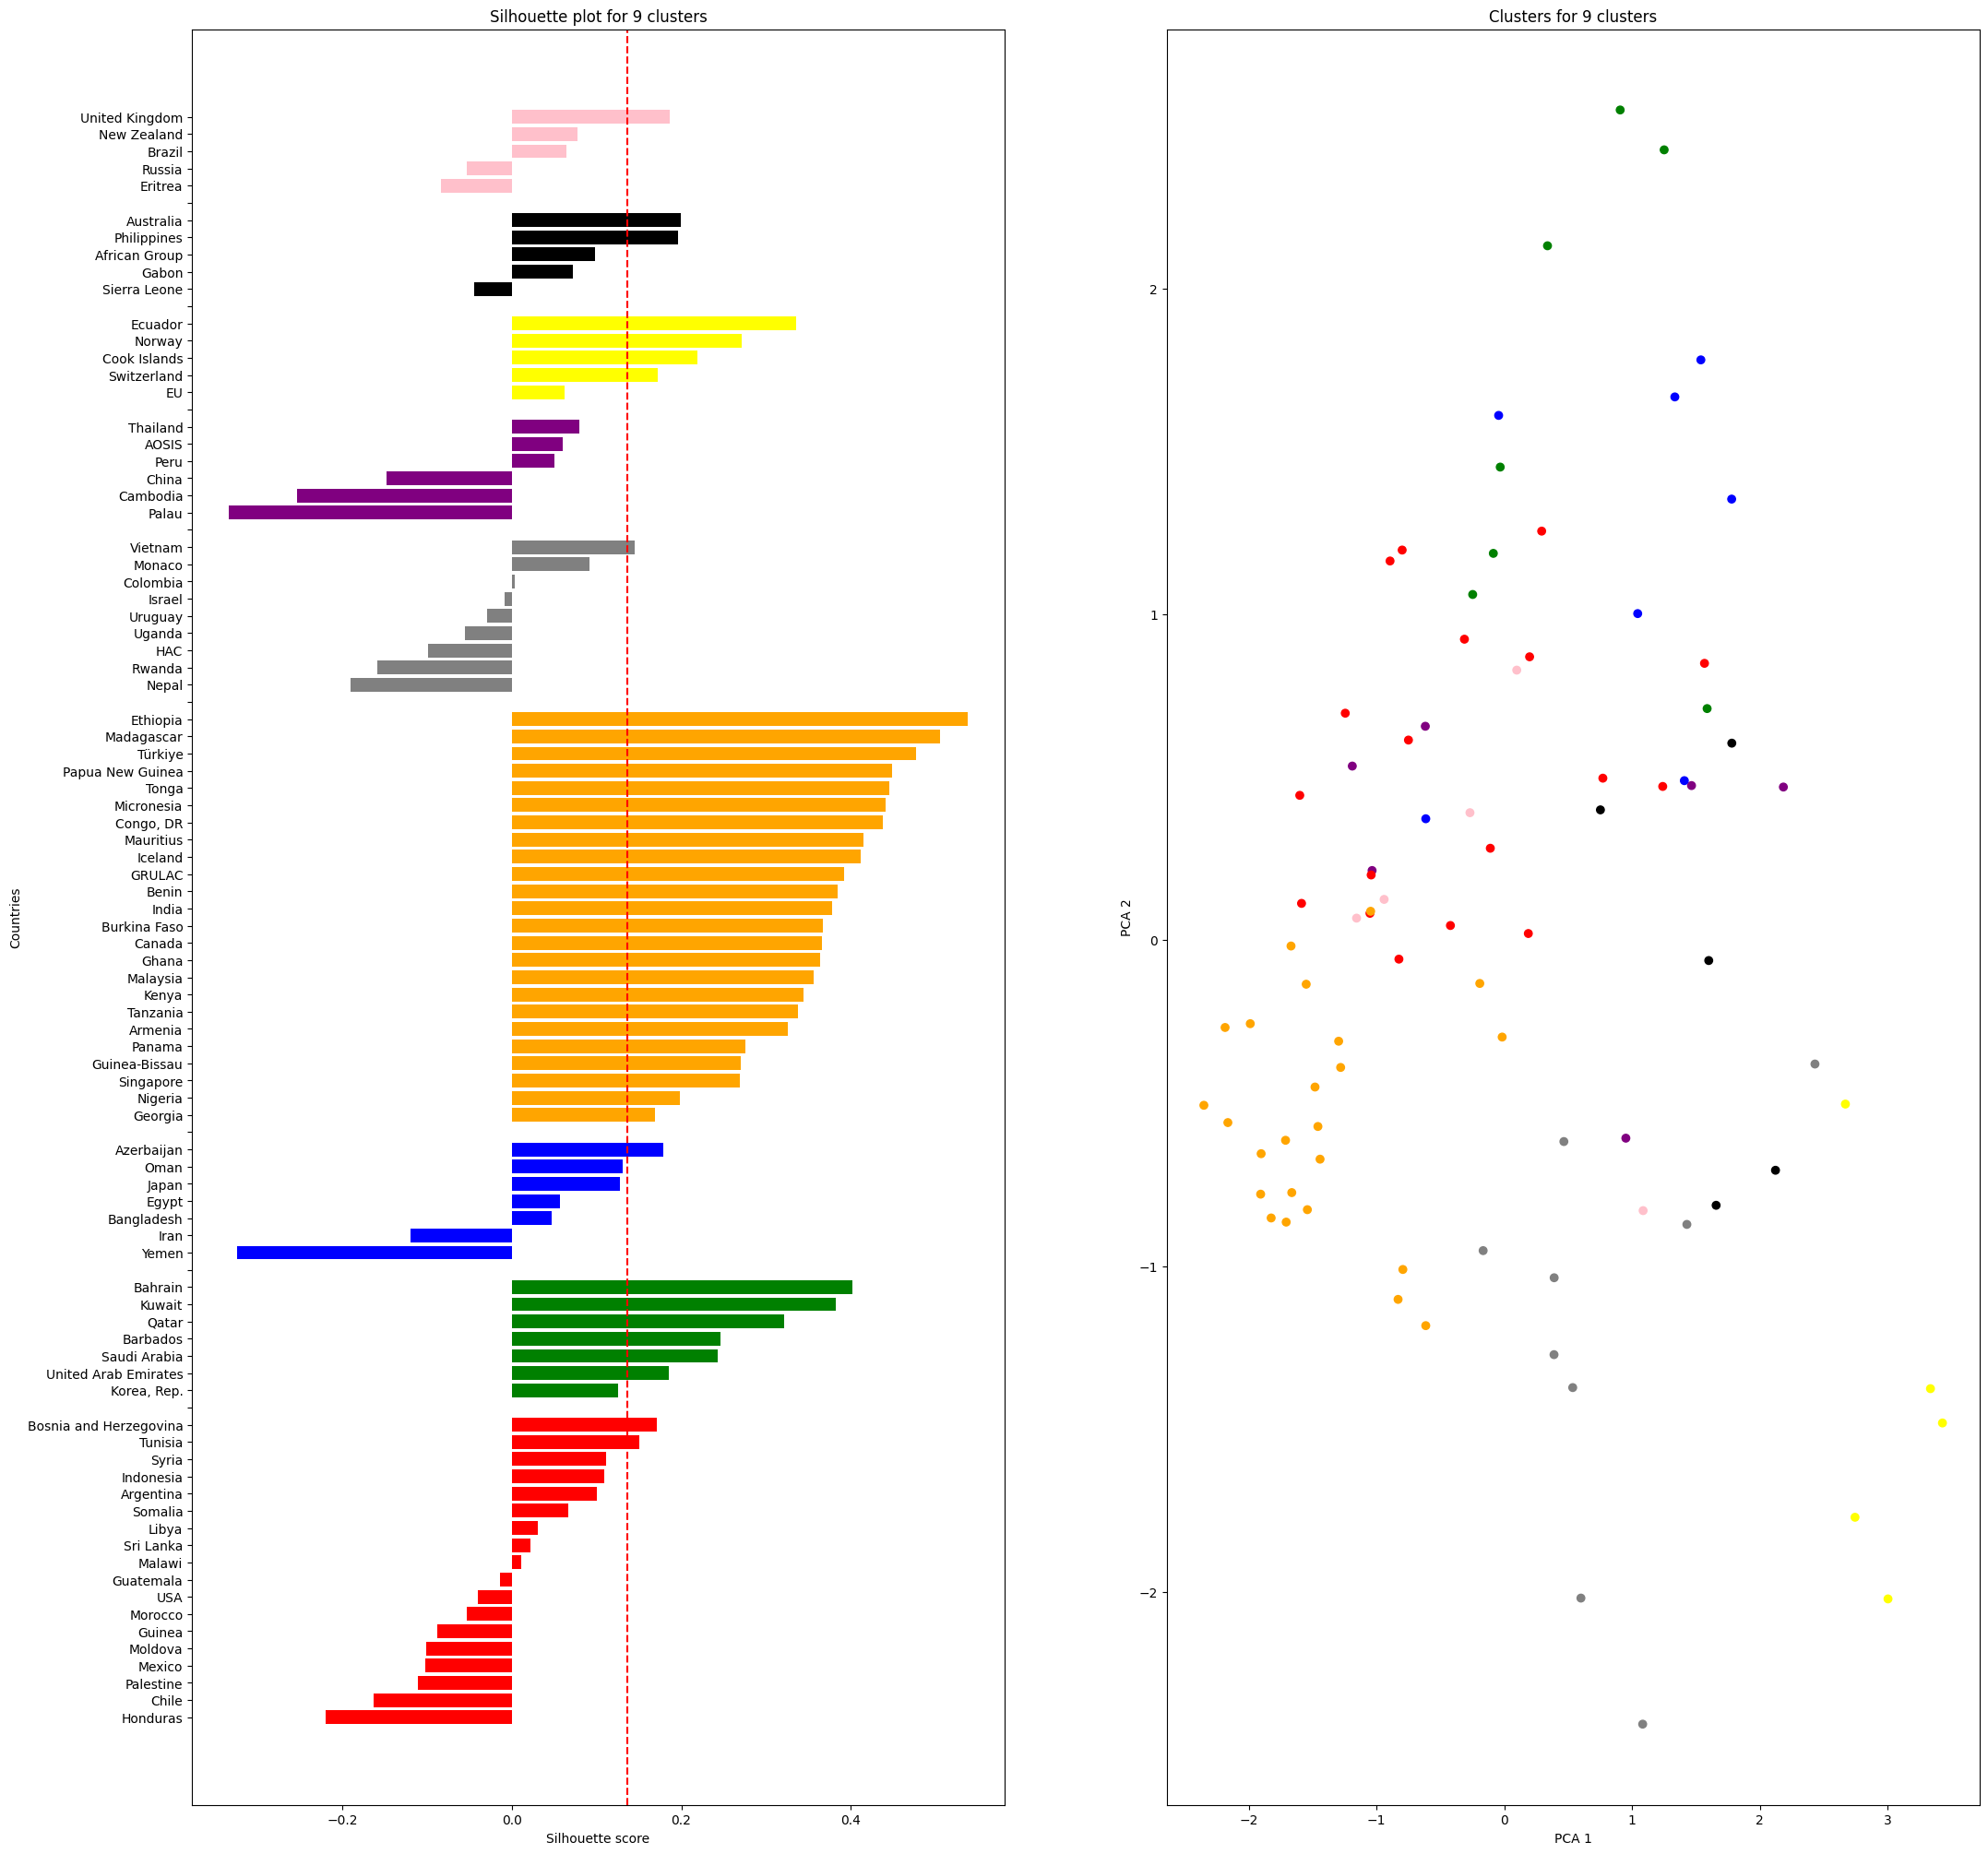

In [19]:
for n_cluster in range(2,10):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(25, 25))
    
    kmodes = KModes(n_clusters=n_cluster, init='Huang', n_init=100, random_state=0).fit(vectors)
    labels = kmodes.labels_
    
    silhouette = np.array(silhouettes_per_k[n_cluster-2])
    silhouette_avg = np.mean(silhouette)
    
    # sort the clusters and sort each cluster by silhouette
    y_lower = 0
    y_ticks = []
    for i_cluster in range(n_cluster):
        cluster = silhouette[labels == i_cluster]
        
        # get countries
        countries_cluster = countries[labels == i_cluster]
        
        ind = np.argsort(cluster)
        cluster = cluster[ind]
        countries_cluster = countries_cluster[ind]
        
        ax1.barh(np.arange(len(cluster))+y_lower, cluster, color=col[i_cluster])
        y_lower += len(cluster)+1
        
        if i_cluster != n_cluster-1:
            # 2 empty spaces at end of cluster
            countries_cluster = np.append(countries_cluster, [''])
        
        
        # save y_ticks
        y_ticks.append(countries_cluster)
    y_ticks = np.concatenate(y_ticks)
    
    ax1.set_yticks(np.arange(len(y_ticks)))
    ax1.set_yticklabels(y_ticks)
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_title('Silhouette plot for ' + str(n_cluster) + ' clusters')
    ax1.set_xlabel('Silhouette score')
    ax1.set_ylabel('Countries')
    
    # plot the clusters
    ax2.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=col[labels])
    ax2.set_title('Clusters for ' + str(n_cluster) + ' clusters')
    ax2.set_xlabel('PCA 1')
    ax2.set_ylabel('PCA 2')
    
    plt.show()
    
        
    
    

1
2
0
3


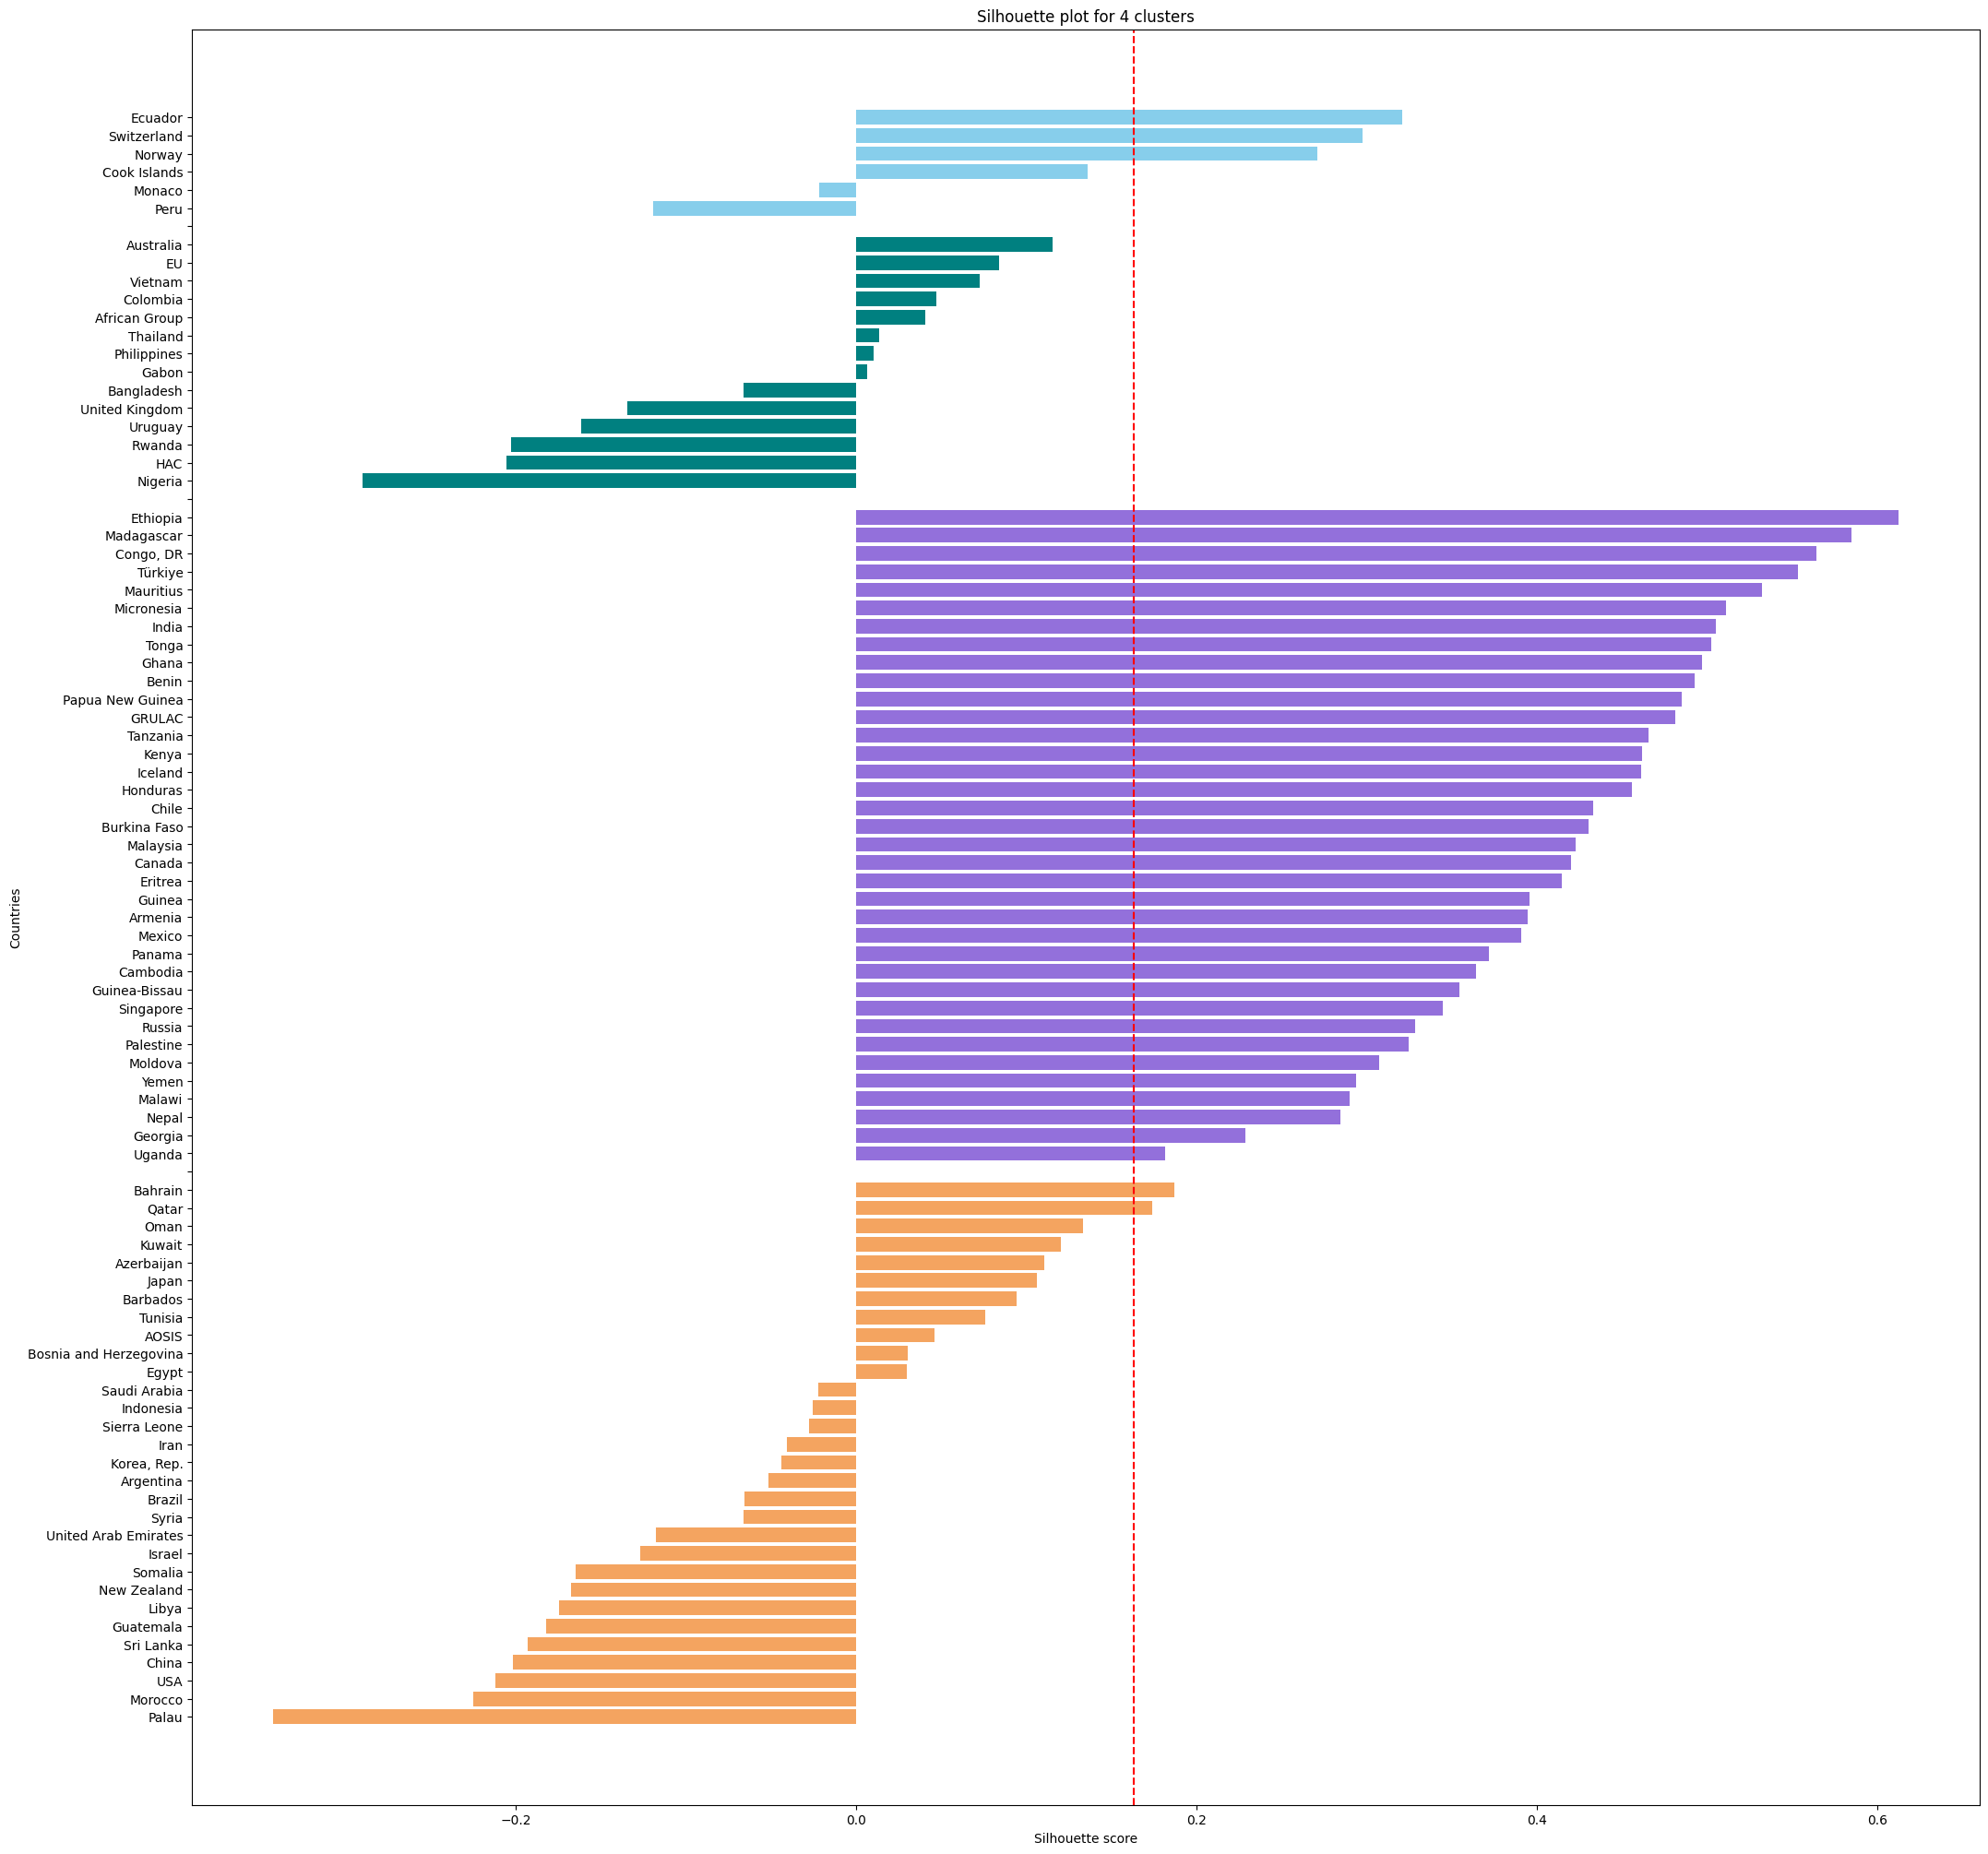

In [24]:
import matplotlib.cm as cm
col = np.array(['teal', 'sandybrown','mediumpurple' , 'skyblue', 'grey','purple', 'yellow', 'black', 'pink', 'brown', 'cyan', 'magenta'])

n_cluster = 4

fig, ax1 = plt.subplots(1,1, figsize=(25, 25))

kmodes = KModes(n_clusters=n_cluster, init='Huang', n_init=100, random_state=0).fit(vectors)
labels = kmodes.labels_

silhouette = np.array(silhouettes_per_k[n_cluster-2])
silhouette_avg = np.mean(silhouette)

y_lower = 0
y_ticks = []
for i_cluster in [1,2,0,3]:
    print(i_cluster)
    cluster = silhouette[labels == i_cluster]
    
    # get countries
    countries_cluster = countries[labels == i_cluster]
    
    ind = np.argsort(cluster)
    cluster = cluster[ind]
    countries_cluster = countries_cluster[ind]
    
    ax1.barh(np.arange(len(cluster))+y_lower, cluster, color=col[i_cluster])
    y_lower += len(cluster)+1
    
    if i_cluster != 3:
        # 2 empty spaces at end of cluster
        countries_cluster = np.append(countries_cluster, [''])
    
    
    # save y_ticks
    y_ticks.append(countries_cluster)
y_ticks = np.concatenate(y_ticks)

ax1.set_yticks(np.arange(len(y_ticks)))
ax1.set_yticklabels(y_ticks)

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_title('Silhouette plot for ' + str(n_cluster) + ' clusters')
ax1.set_xlabel('Silhouette score')
ax1.set_ylabel('Countries')

plt.savefig('Figures/silhouette_kmodes.svg')
plt.show()


0
1
2
3


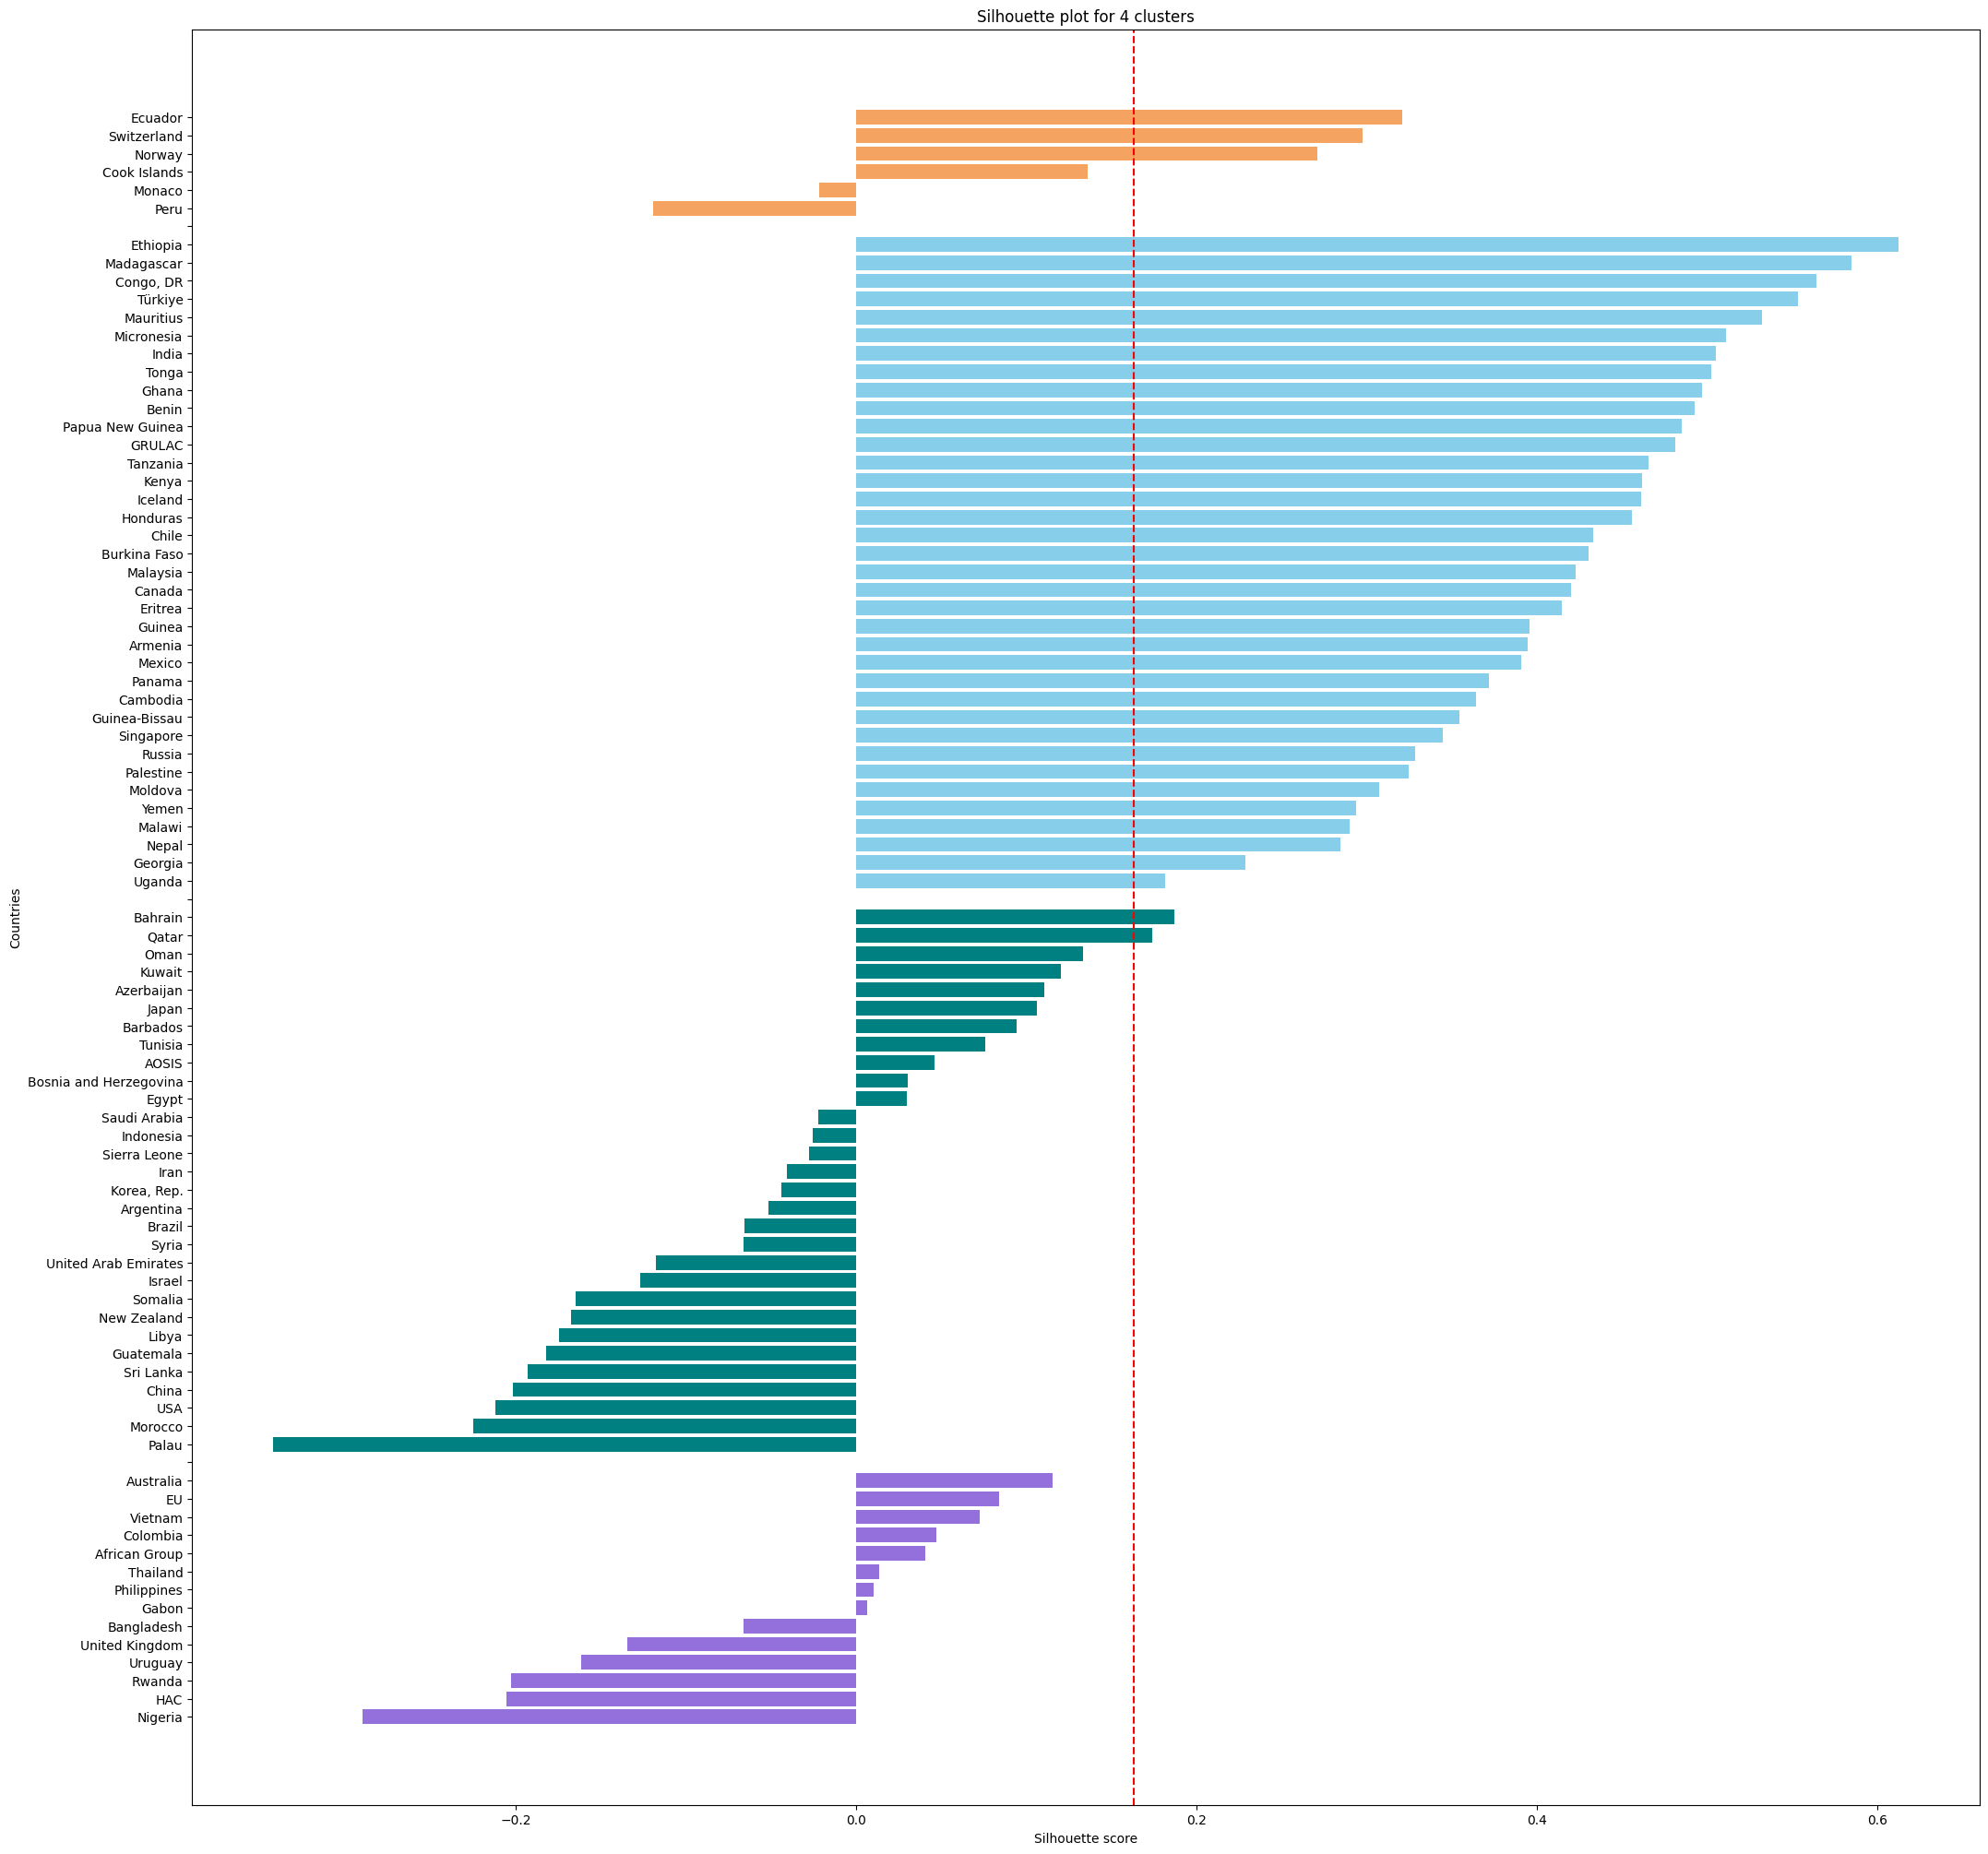

In [15]:
# do the same as above but move the 4th cluster to second position, 2nd to 3rd and 3rd to 4th

import matplotlib.cm as cm
col = np.array(['sandybrown', 'mediumpurple','teal' , 'skyblue', 'grey','purple', 'yellow', 'black', 'pink', 'brown', 'cyan', 'magenta'])

n_cluster = 4

fig, ax1 = plt.subplots(1,1, figsize=(25, 25))

kmodes = KModes(n_clusters=n_cluster, init='Huang', n_init=100, random_state=0).fit(vectors)
labels = kmodes.labels_

silhouette = np.array(silhouettes_per_k[n_cluster-2])
silhouette_avg = np.mean(silhouette)

y_lower = 0
y_ticks = []
for i_cluster in range(n_cluster):
    print(i_cluster)
    cluster = silhouette[labels == i_cluster]
    
    # get countries
    countries_cluster = countries[labels == i_cluster]
    
    ind = np.argsort(cluster)
    cluster = cluster[ind]
    countries_cluster = countries_cluster[ind]
    
    ax1.barh(np.arange(len(cluster))+y_lower, cluster, color=col[(i_cluster+1)%4])
    y_lower += len(cluster)+1
    
    if i_cluster != n_cluster-1:
        # 2 empty spaces at end of cluster
        countries_cluster = np.append(countries_cluster, [''])
    
    
    # save y_ticks
    y_ticks.append(countries_cluster)
y_ticks = np.concatenate(y_ticks)

ax1.set_yticks(np.arange(len(y_ticks)))
ax1.set_yticklabels(y_ticks)

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_title('Silhouette plot for ' + str(n_cluster) + ' clusters')
ax1.set_xlabel('Silhouette score')
ax1.set_ylabel('Countries')

plt.savefig('Figures/silhouette_kmodes_reordered.pdf')
plt.show()


Calculating:   0%|          | 0/5 [00:00<?, ?it/s]

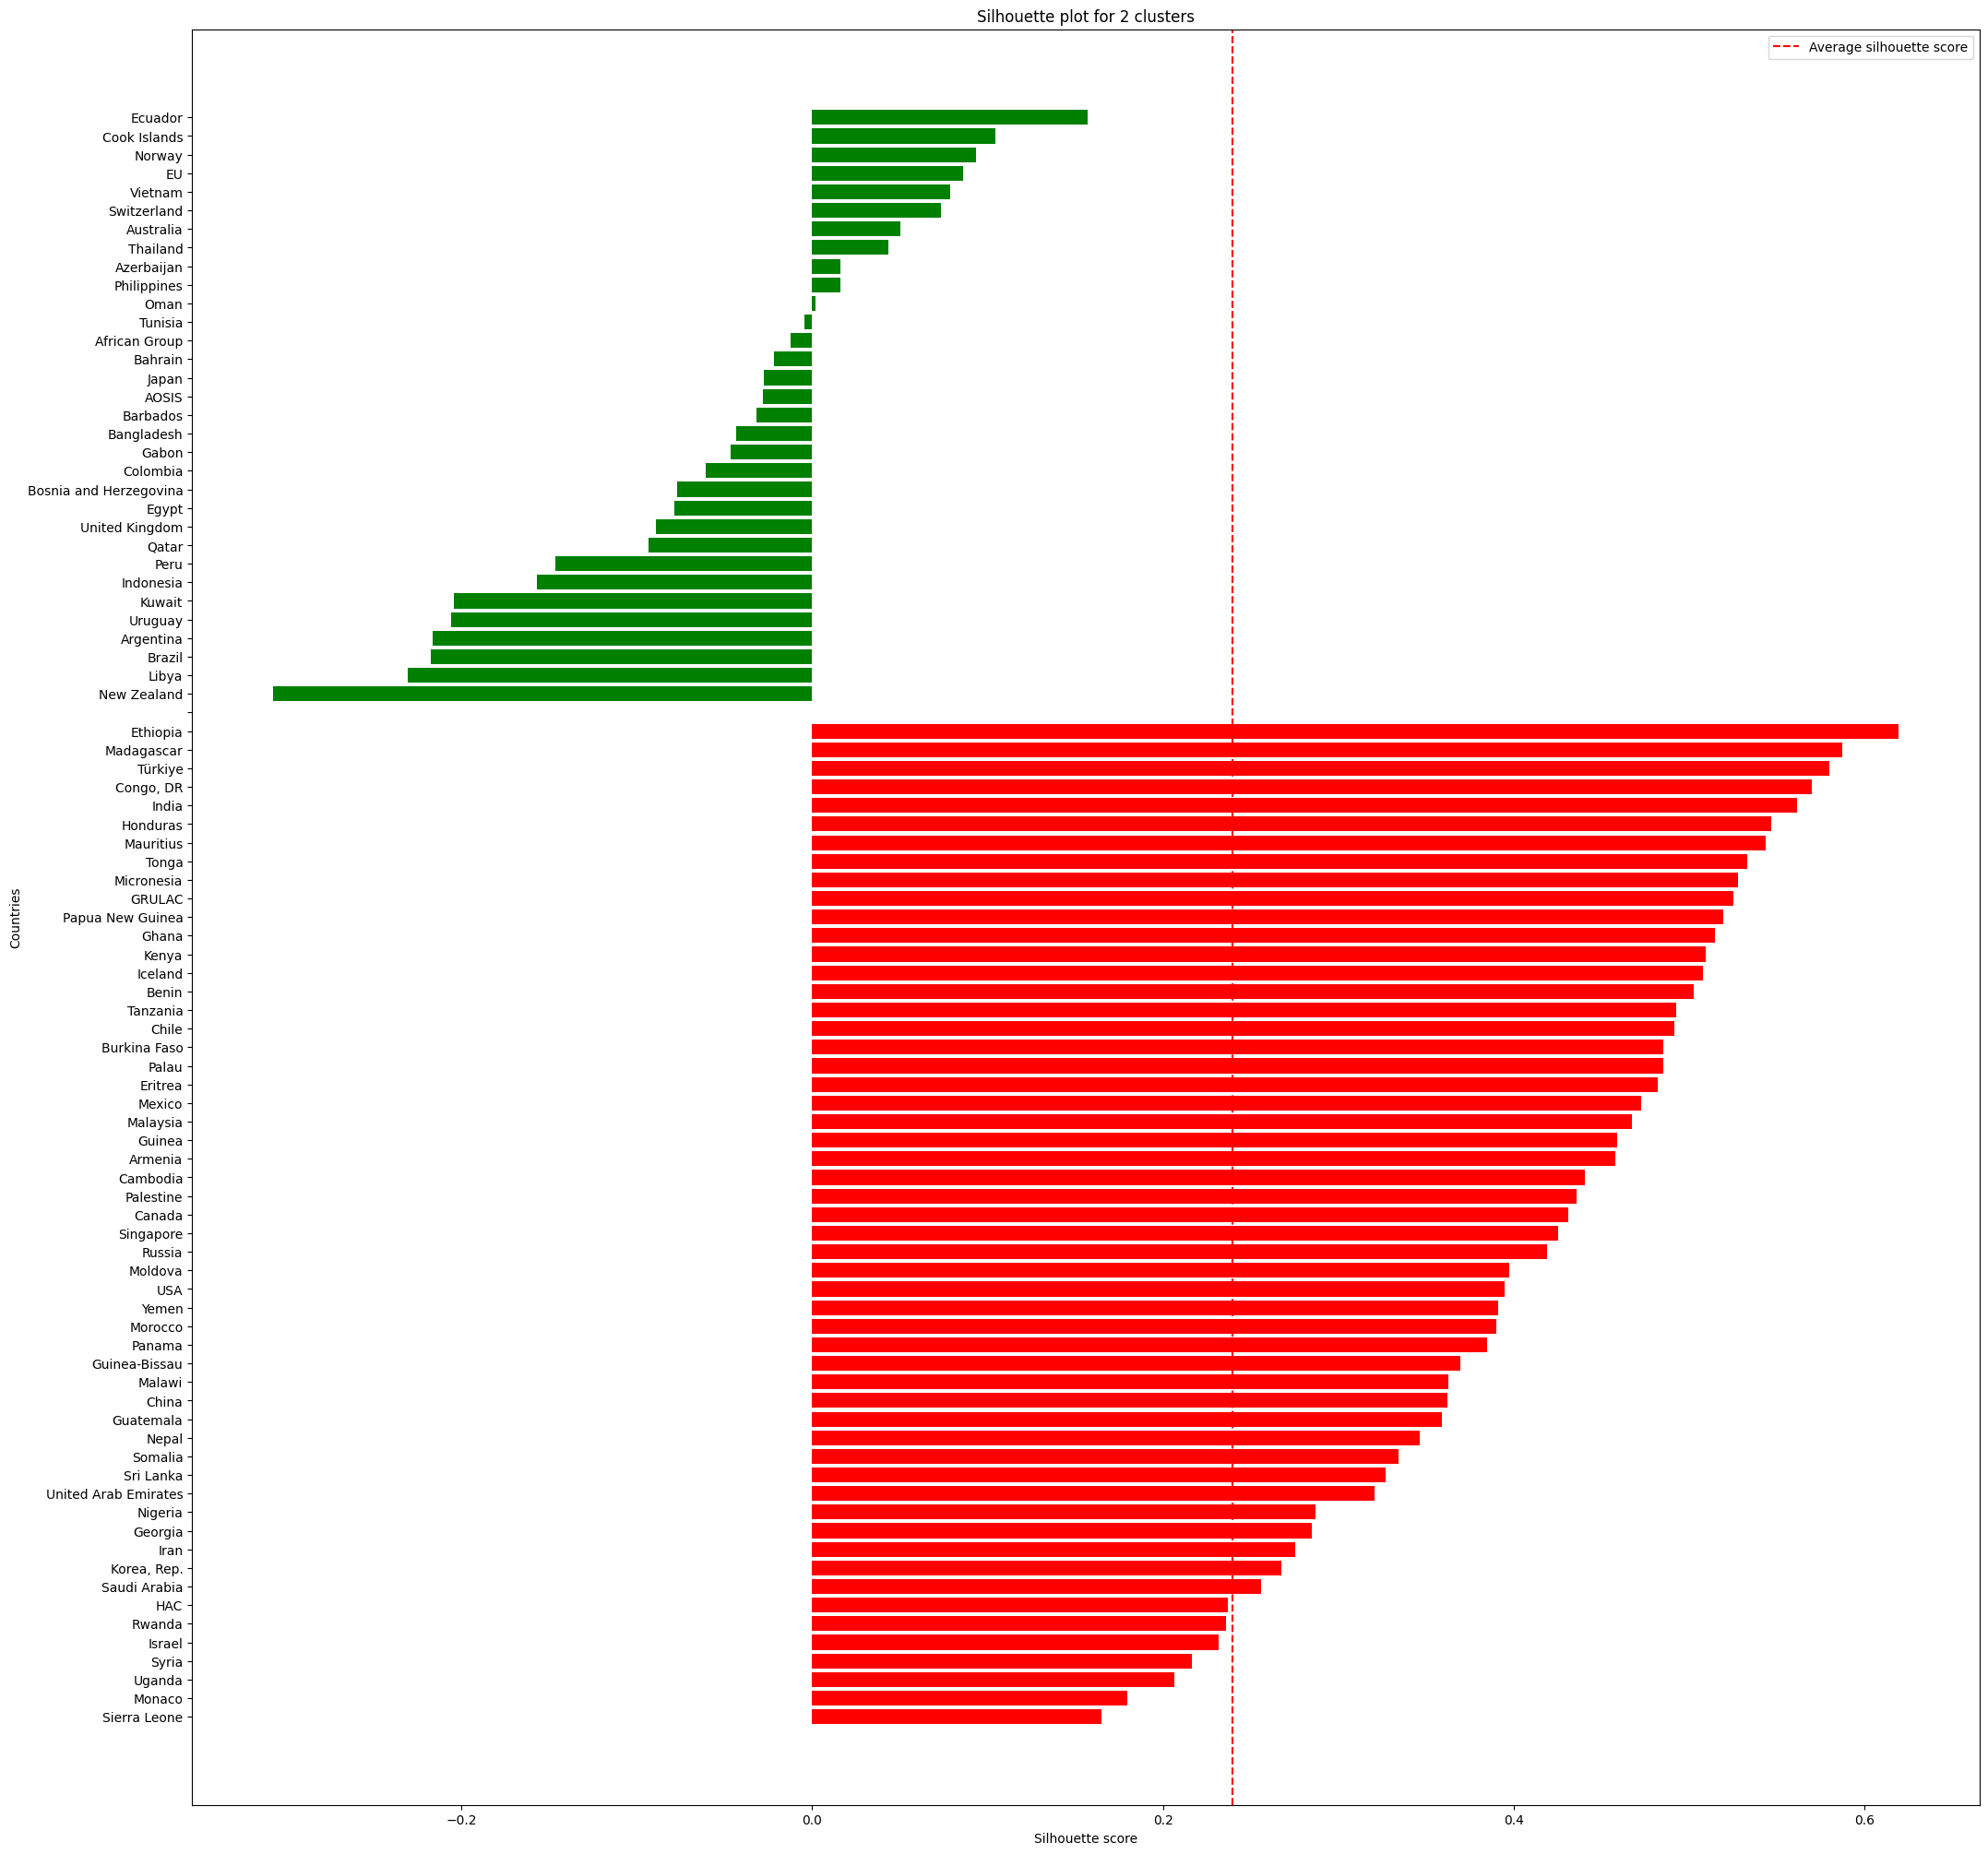

Calculating:  20%|██        | 1/5 [00:06<00:27,  6.82s/it]

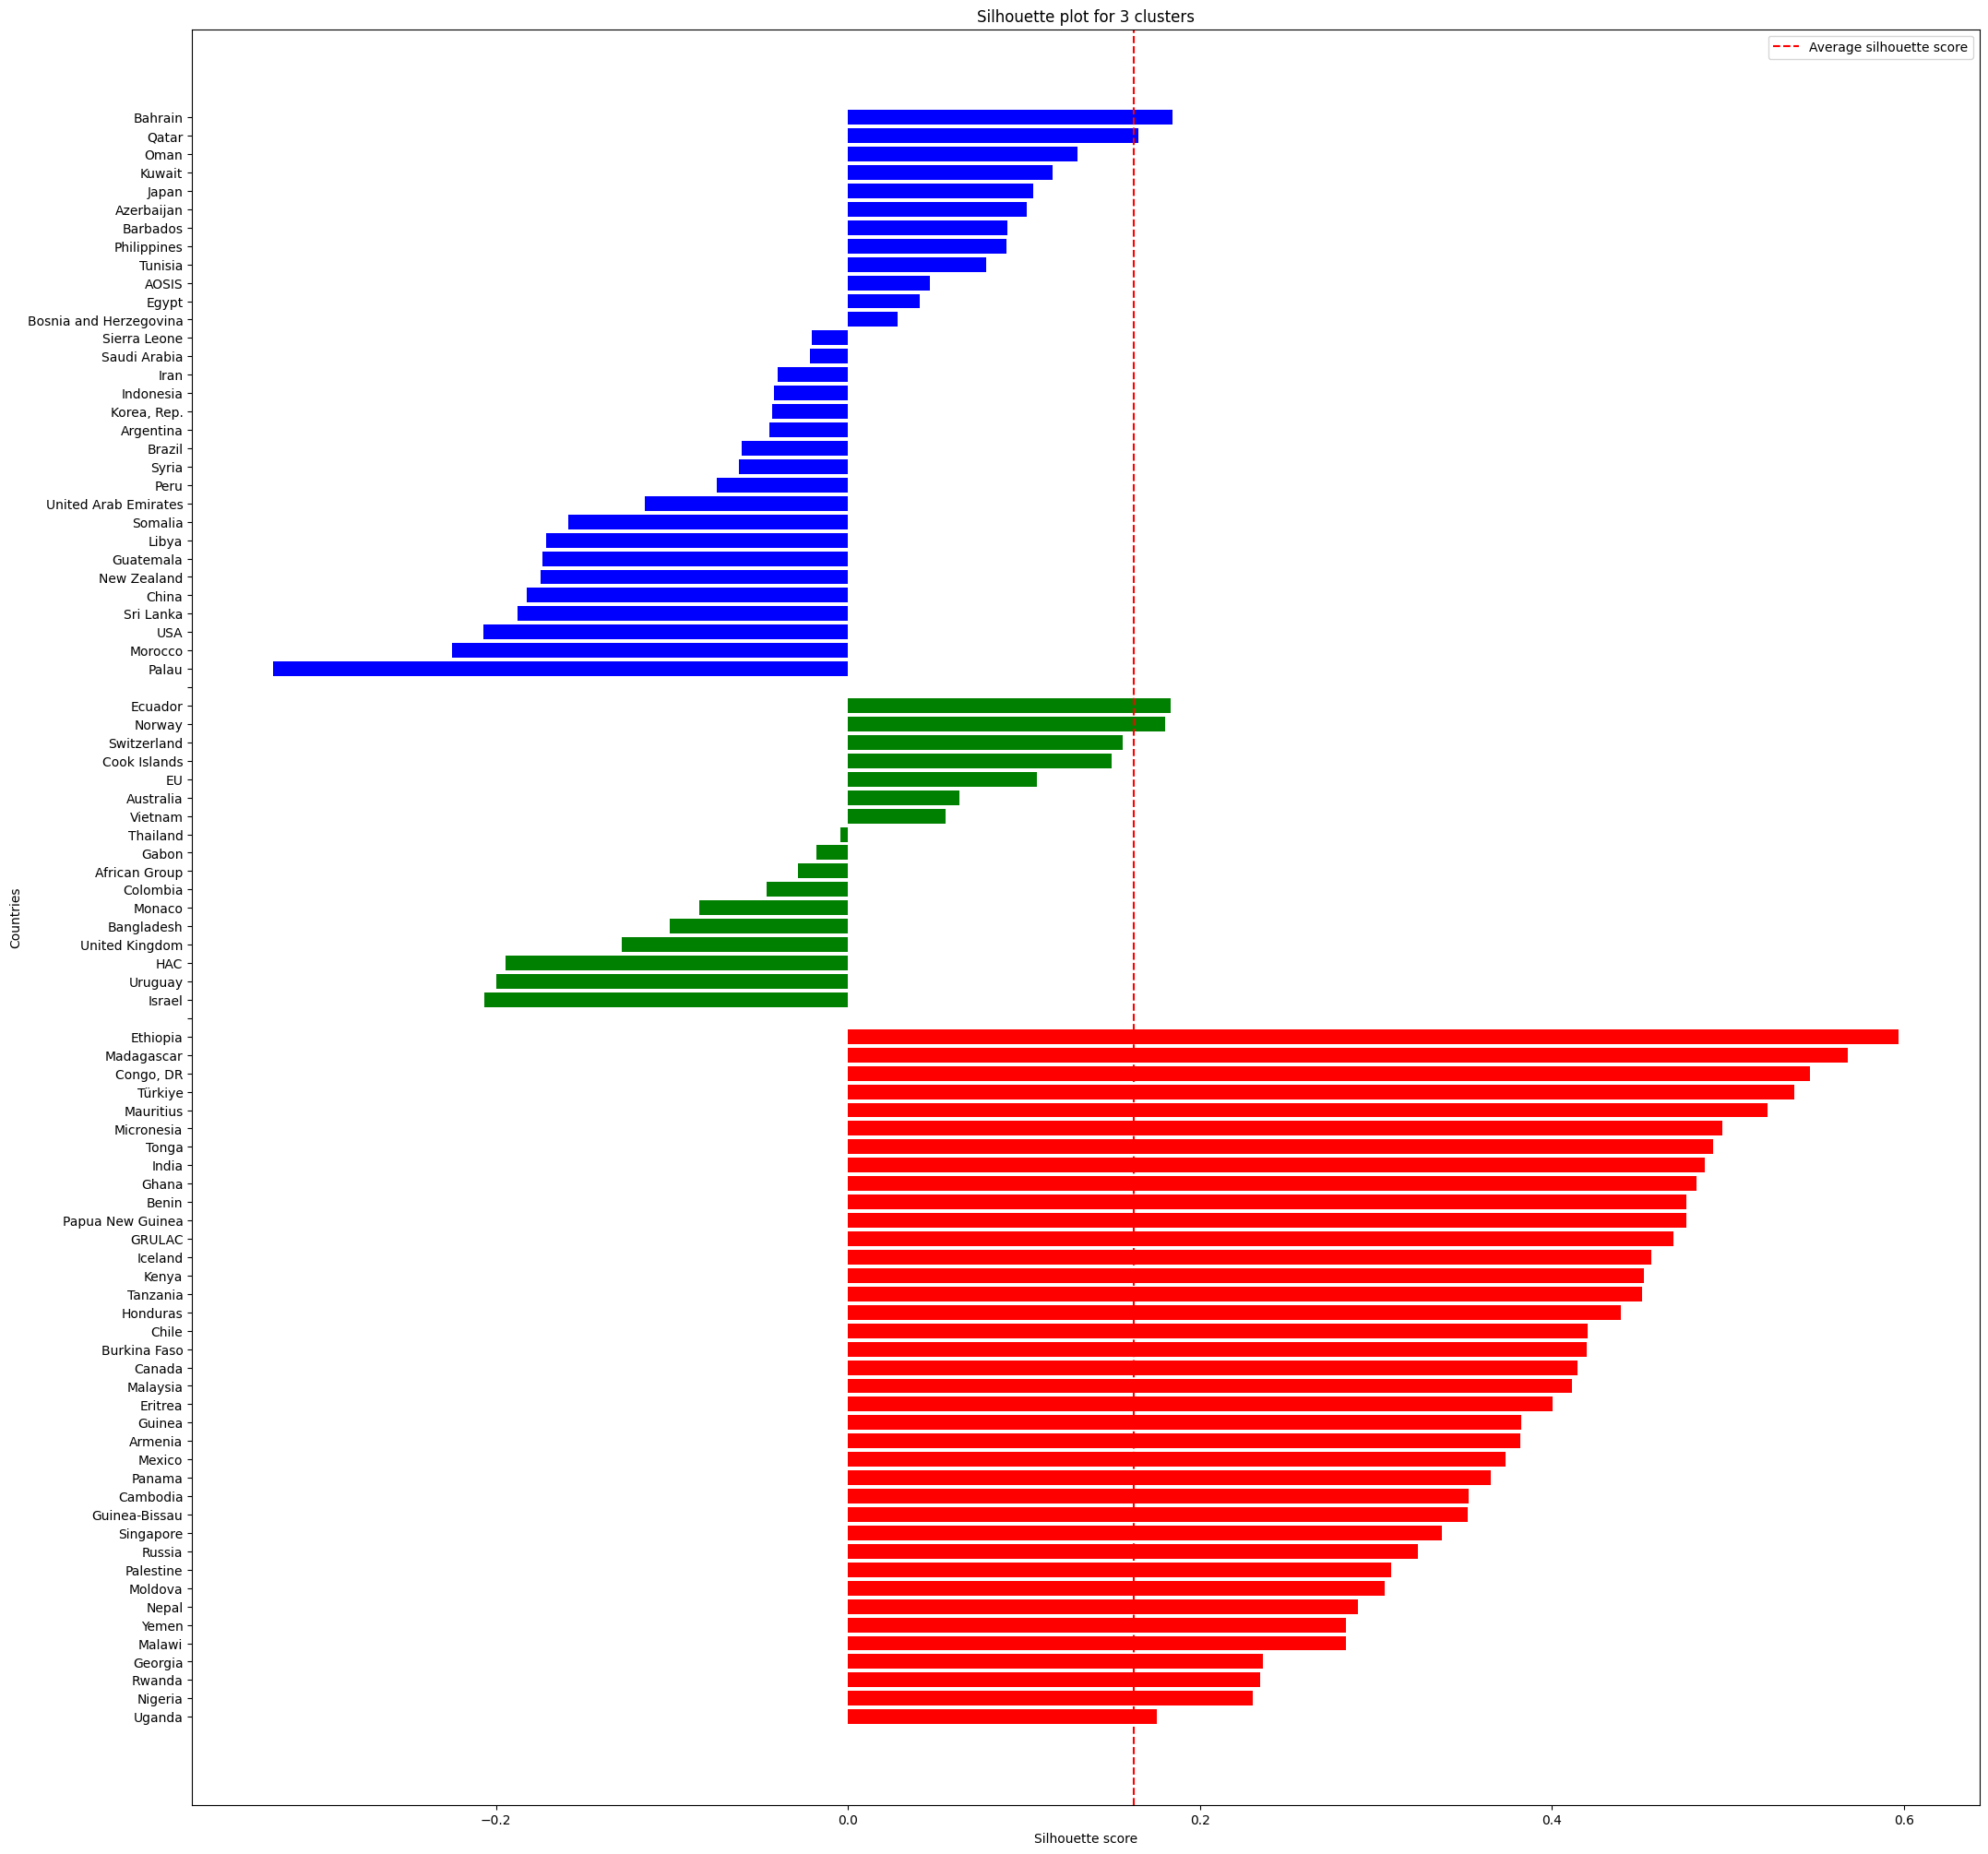

Calculating:  40%|████      | 2/5 [00:16<00:25,  8.43s/it]

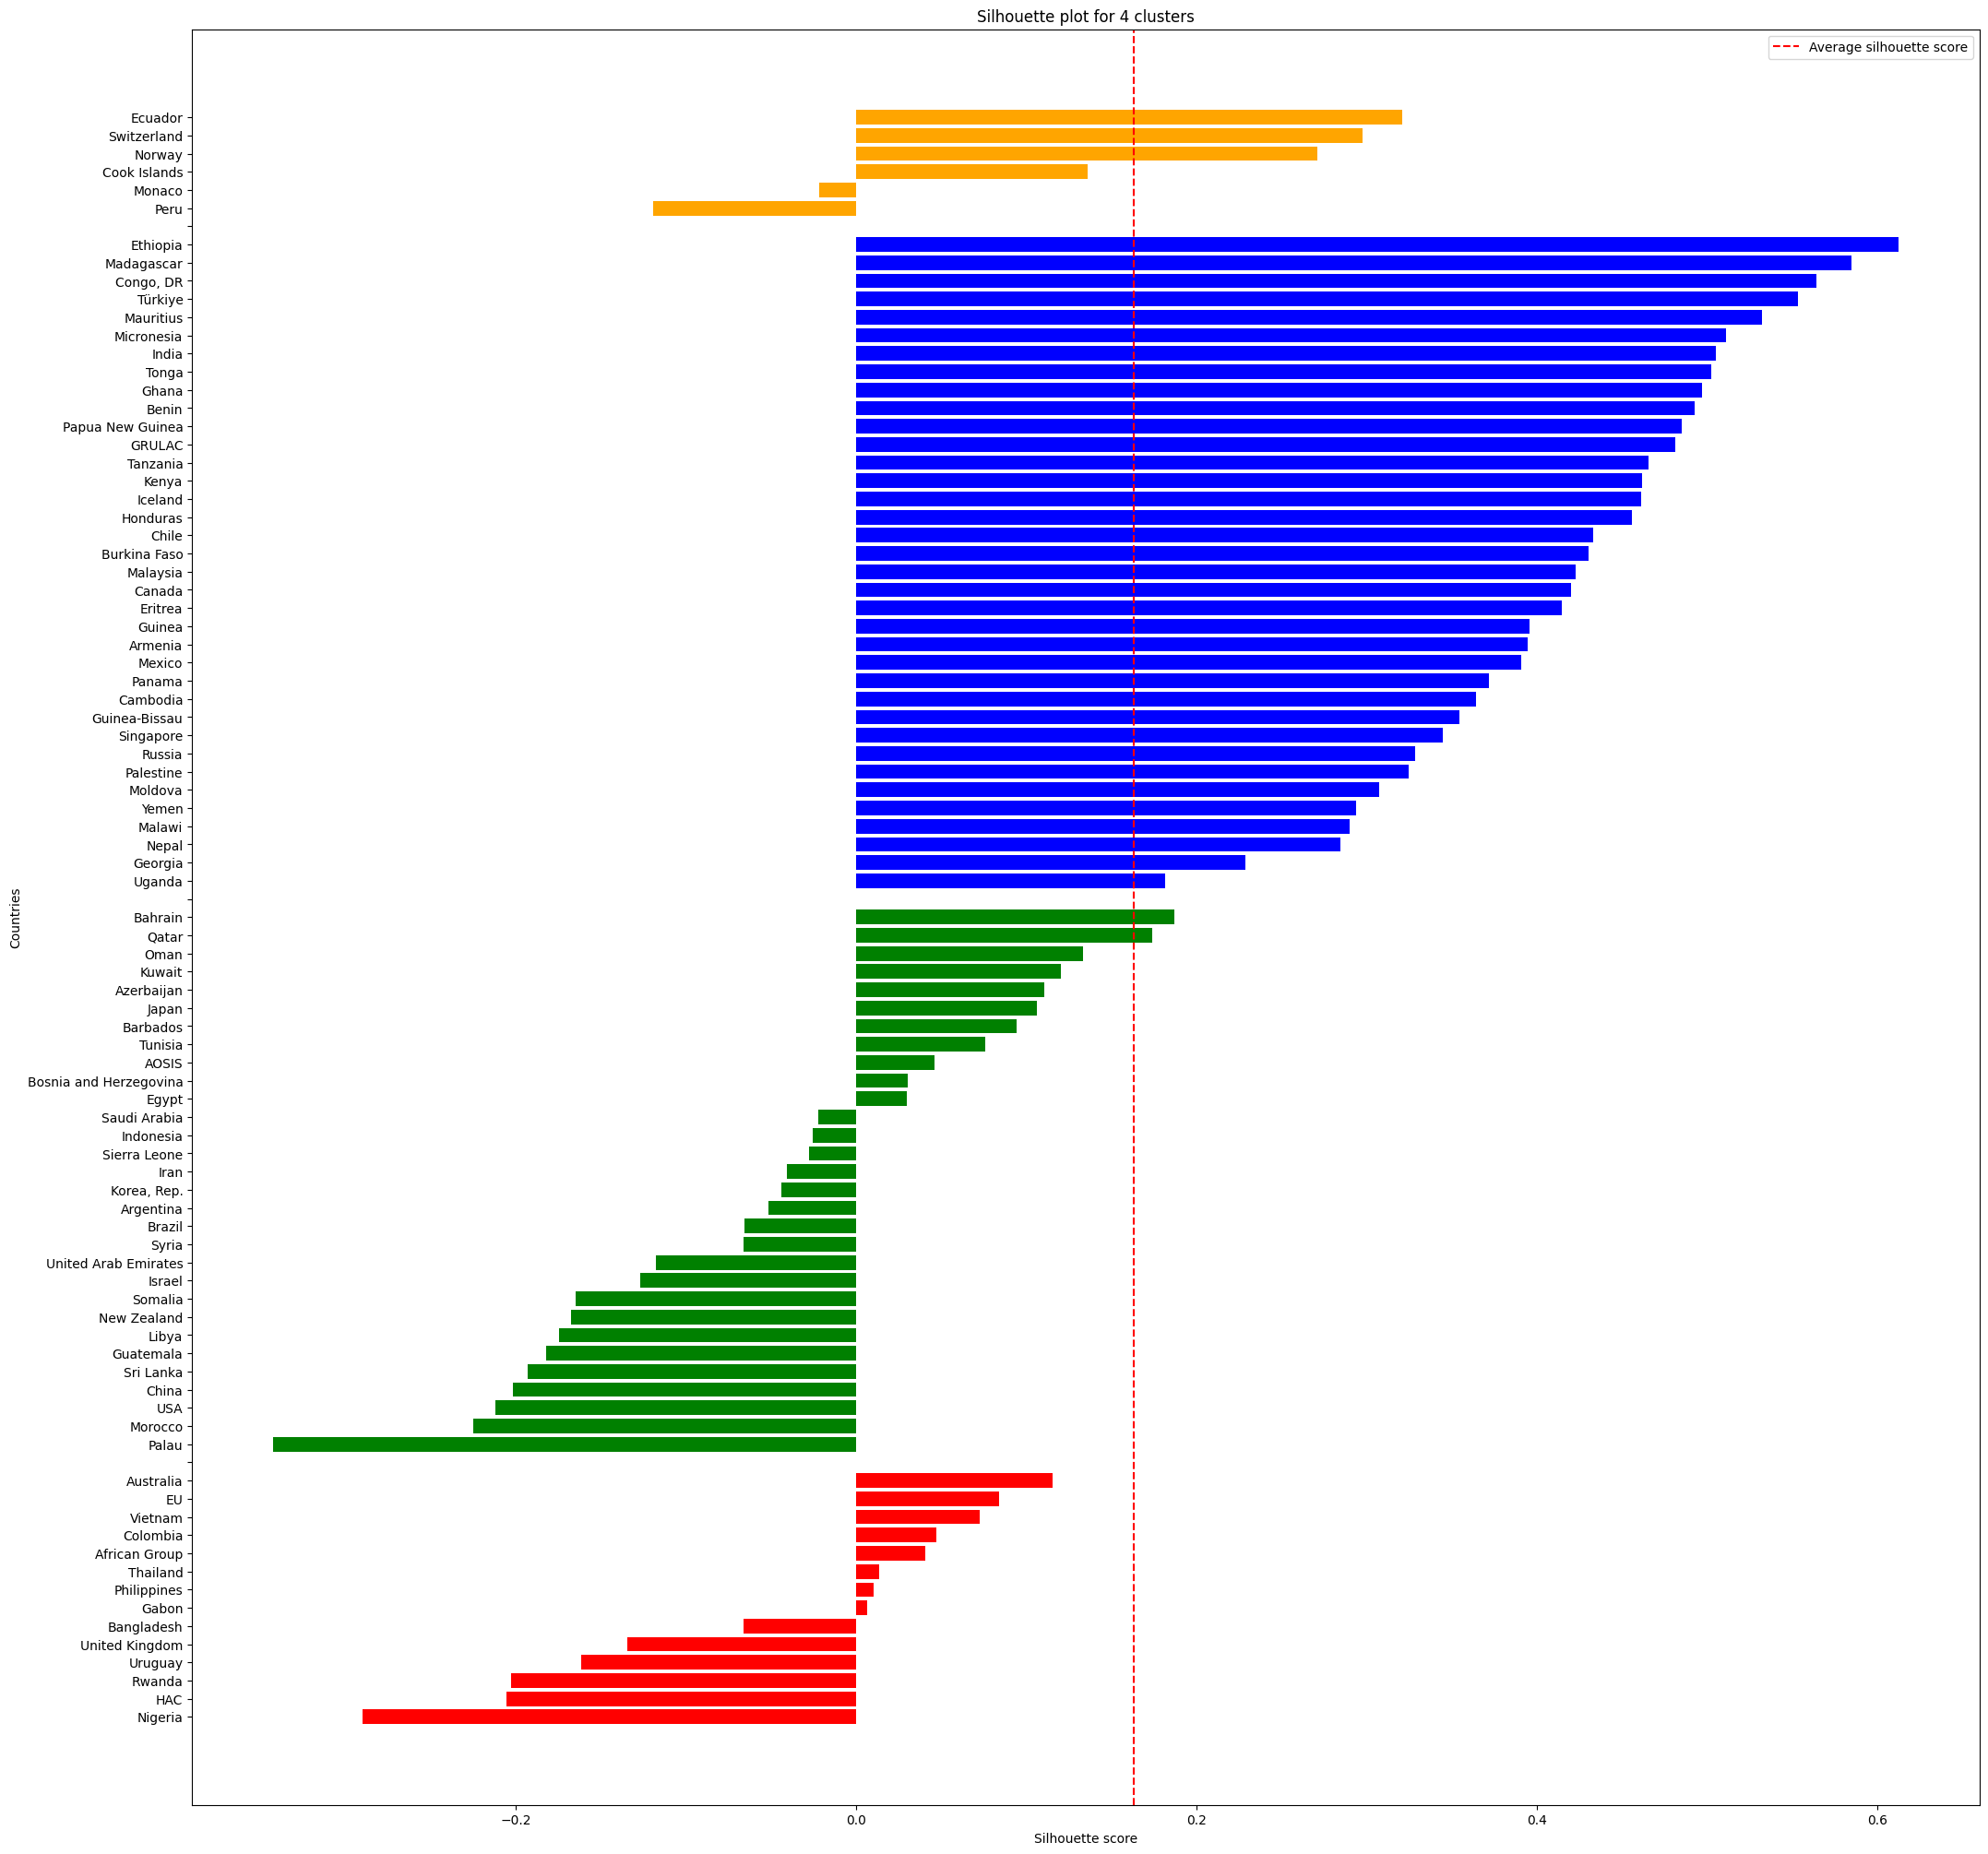

Calculating:  60%|██████    | 3/5 [00:26<00:18,  9.10s/it]

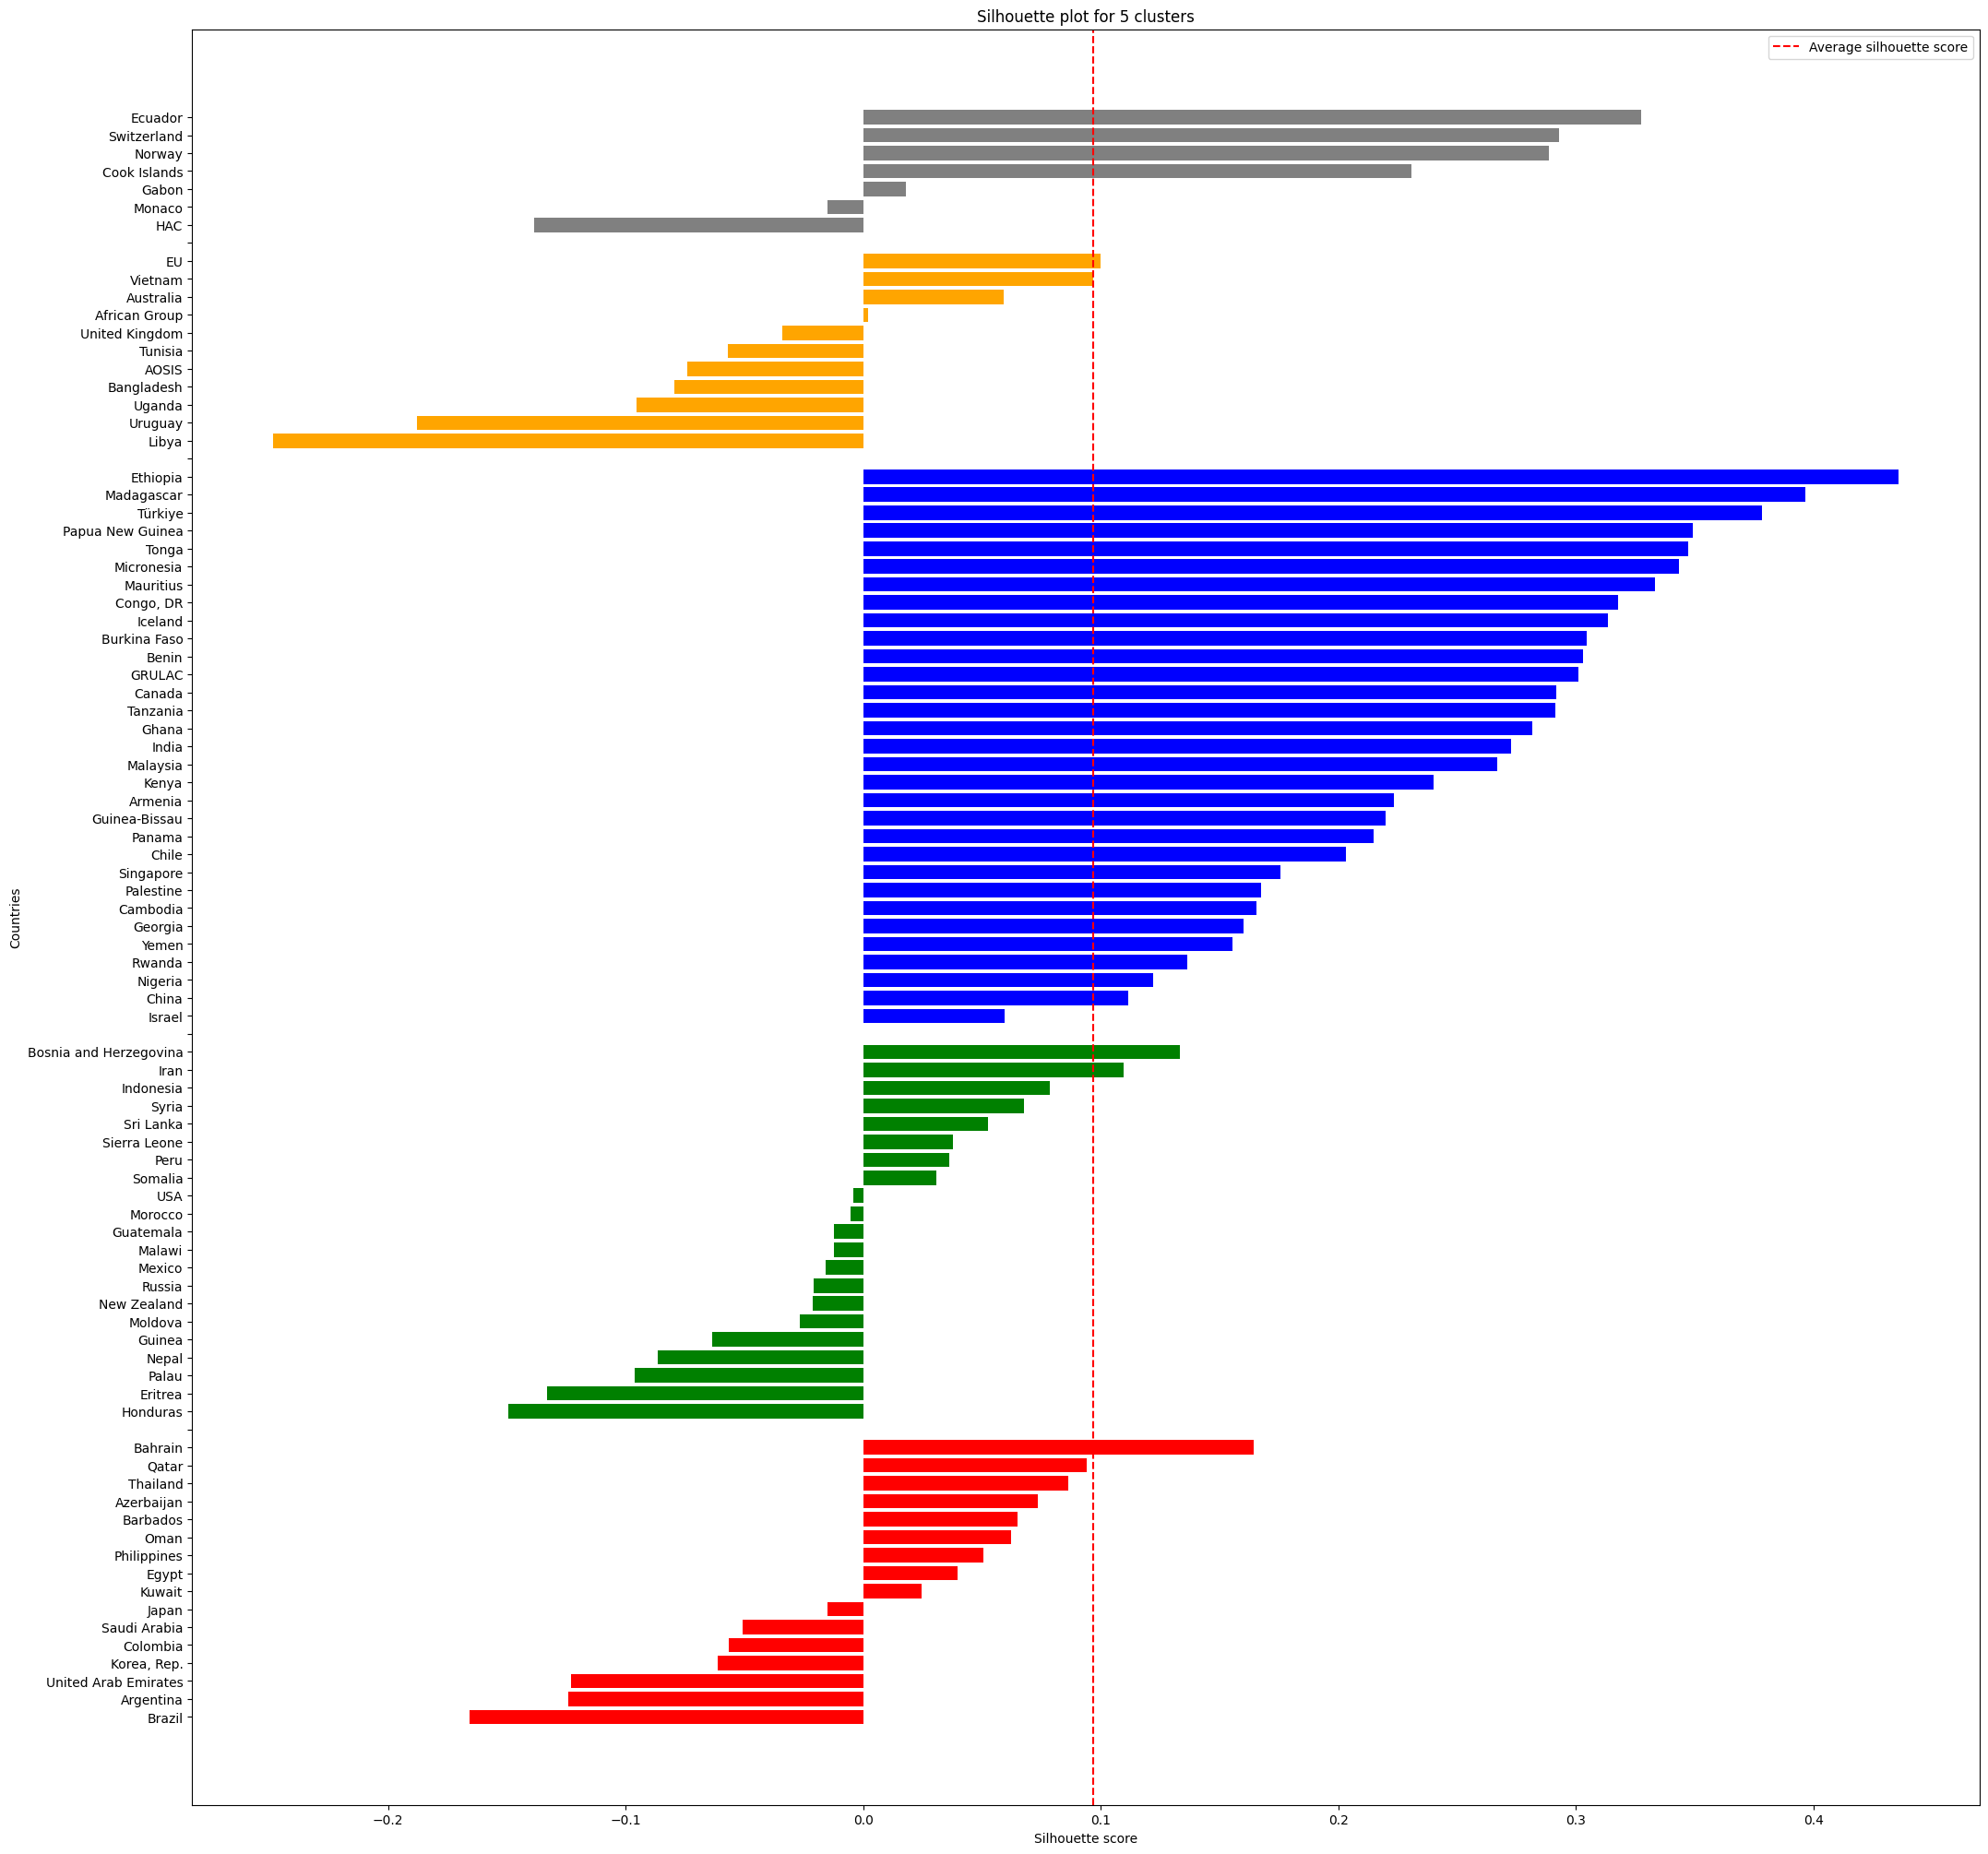

Calculating:  80%|████████  | 4/5 [00:37<00:09,  9.83s/it]

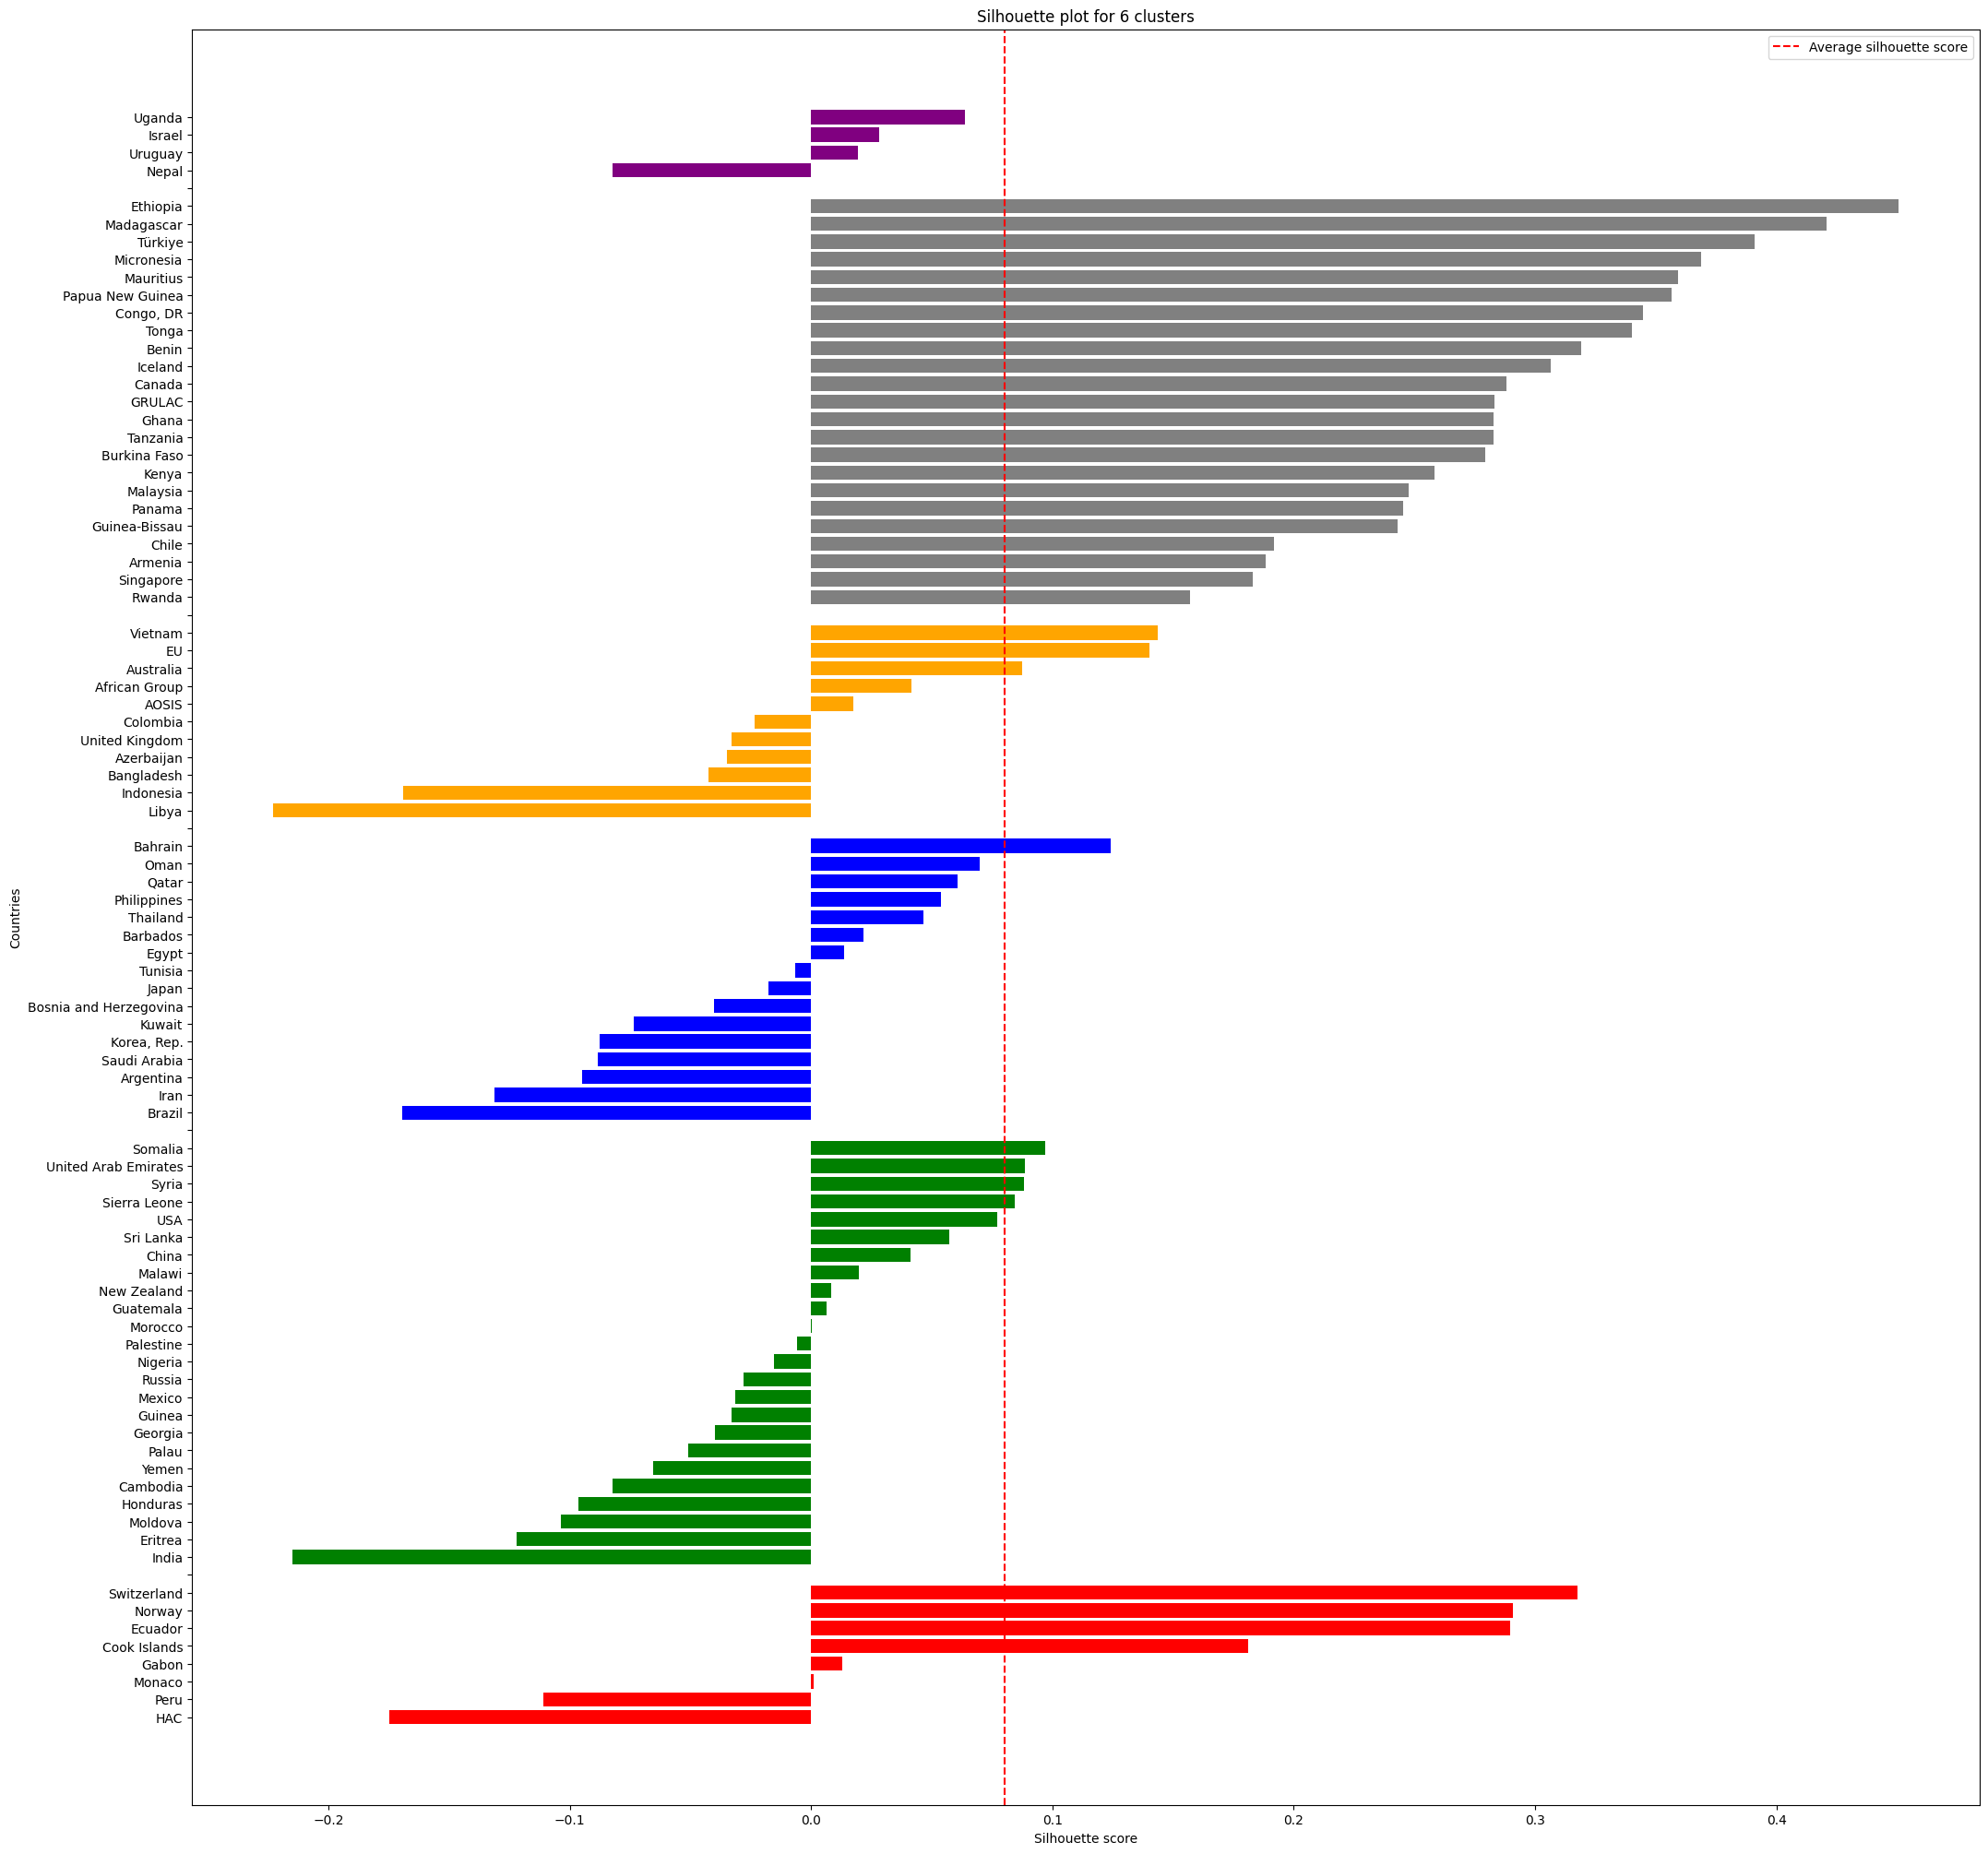

Calculating: 100%|██████████| 5/5 [00:48<00:00,  9.77s/it]


In [10]:
import matplotlib.cm as cm
col = np.array(['red', 'green', 'blue', 'orange', 'grey','purple', 'yellow', 'black', 'pink', 'brown', 'cyan', 'magenta'])

for n_cluster in trange(2,7, desc="Calculating"):
    fig, ax1 = plt.subplots(1,1, figsize=(25, 25))
    
    kmodes = KModes(n_clusters=n_cluster, init='Huang', n_init=100, random_state=0).fit(vectors)
    labels = kmodes.labels_
    
    silhouette = np.array(silhouettes_per_k[n_cluster-2])
    silhouette_avg = np.mean(silhouette)
    
    y_lower = 0
    y_ticks = []
    for i_cluster in range(n_cluster):
        cluster = silhouette[labels == i_cluster]
        
        # get countries
        countries_cluster = countries[labels == i_cluster]
        
        ind = np.argsort(cluster)
        cluster = cluster[ind]
        countries_cluster = countries_cluster[ind]
        
        ax1.barh(np.arange(len(cluster))+y_lower, cluster, color=col[i_cluster])
        y_lower += len(cluster)+1
        
        if i_cluster != n_cluster-1:
            # 2 empty spaces at end of cluster
            countries_cluster = np.append(countries_cluster, [''])
        
        
        # save y_ticks
        y_ticks.append(countries_cluster)
    y_ticks = np.concatenate(y_ticks)
    
    ax1.set_yticks(np.arange(len(y_ticks)))
    ax1.set_yticklabels(y_ticks)
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label='Average silhouette score')
    ax1.set_title('Silhouette plot for ' + str(n_cluster) + ' clusters')
    ax1.set_xlabel('Silhouette score')
    ax1.set_ylabel('Countries')
    plt.legend()
    
    plt.savefig('Figures/Silhouette/silhouette_kmodes_' + str(n_cluster) + '.pdf')
    plt.show()
